In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold
import numpy as np
import phik
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from helper import *
from plots import *
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE






In [2]:
SEED = 42

In [3]:
def evaluate_models_cv(models, X, y, preprocessor=None, cv=5, seed=None):
    """
    Проводит кросс-валидацию для набора моделей и возвращает таблицу метрик.
    
    Параметры:
        models (list): список кортежей ('ModelName', model_object)
        X, y: признаки и целевая переменная
        preprocessor: препроцессор (ColumnTransformer или Pipeline)
        cv: число фолдов
        seed: случайное зерно для воспроизводимости

    Возвращает:
        pd.DataFrame с усреднёнными метриками
    """
    all_metrics = {}

    # Набор метрик для оценки
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_macro',
        'recall': 'recall_macro',
        'f1': 'f1_macro',
        'roc_auc': 'roc_auc'
    }

    for name, model in models:
        print(f"\n{'='*60}\nКросс-валидация модели: {name}\n{'='*60}")

        # Устанавливаем seed, если возможно
        if seed is not None:
            if hasattr(model, 'random_state'):
                model.set_params(random_state=seed)
            elif hasattr(model, 'seed'):
                model.set_params(seed=seed)

        # создаём пайплайн
        if preprocessor is not None:
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', model)
            ])
        else:
            pipeline = model

        # Кросс-валидация
        cv_results = cross_validate(
            pipeline,
            X,
            y,
            cv=cv,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1
        )

        # Средние значения метрик
        metrics_mean = {metric.replace("test_", ""): np.mean(values)
                        for metric, values in cv_results.items()
                        if metric.startswith("test_")}

        all_metrics[name] = metrics_mean

        # Краткий вывод
        print(f"Accuracy:  {metrics_mean['accuracy']:.4f}")
        print(f"Precision: {metrics_mean['precision']:.4f}")
        print(f"Recall:    {metrics_mean['recall']:.4f}")
        print(f"F1 Score:  {metrics_mean['f1']:.4f}")
        print(f"ROC AUC:   {metrics_mean['roc_auc']:.4f}")

    # объединяем в таблицу
    df_results = pd.DataFrame(all_metrics).T.sort_values(by="roc_auc", ascending=False)
    print("\n=== Сводная таблица метрик (усреднённые по CV) ===")
    print(df_results.to_string(float_format="%.4f"))

    return df_results


In [4]:
def compare_datasets_results(df1, df2, name1="Dataset_1", name2="Dataset_2", plot=True):
    """
    Сравнивает результаты моделей между двумя наборами данных.

    Параметры:
        df1, df2: DataFrame — таблицы метрик (из evaluate_models_cv)
        name1, name2: подписи для наборов данных
        plot: bool — строить ли графики

    Возвращает:
        DataFrame с разницей метрик (df2 - df1)
    """
    # Проверим, что модели совпадают
    common_models = df1.index.intersection(df2.index)
    if len(common_models) == 0:
        raise ValueError("Нет общих моделей для сравнения!")

    # Вычисляем разницу (вторая - первая)
    diff = df2.loc[common_models] - df1.loc[common_models]
    diff = diff.round(4)

    print(f"\n=== Разница метрик ({name2} - {name1}) ===")
    print(diff)

    # Визуализация
    if plot:
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, len(diff.columns), figsize=(18, 4), sharey=True)
        fig.suptitle(f"Изменение метрик между {name1} и {name2}", fontsize=14)

        for ax, metric in zip(axes, diff.columns):
            diff[metric].plot(kind='bar', ax=ax, title=metric)
            ax.axhline(0, color='black', linewidth=0.8)
            ax.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    return diff


In [5]:
def make_preprocessor(X, num_cols, cat_cols):
    available_cols = X.columns.tolist()
    num_cols = [c for c in num_cols if c in available_cols]
    cat_cols = [c for c in cat_cols if c in available_cols]
    
    print("Используемые числовые признаки:", num_cols)
    print("Используемые категориальные признаки:", cat_cols)
    
    return ColumnTransformer([
        ('num', SimpleImputer(strategy='mean'), num_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
    ], remainder='passthrough')


In [6]:
def evaluate_classification(y_test, y_pred, y_probs=None, model_name="Model"):
    print(f"=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, pos_label='Yes'))
    if y_probs is not None:
        y_test_num = y_test.map({'No':0, 'Yes':1})
        print("ROC AUC:", roc_auc_score(y_test_num, y_probs))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def classification_metrics(y_test, y_pred, y_probs=None, model_name="Model"):
    """
    Выводит основные метрики классификации и возвращает их в виде словаря.
    Поддерживает как бинарные метки (0/1), так и строковые ('Yes'/'No').
    """
    print(f"=== {model_name} ===")
    
    # Преобразуем метки в числа для ROC AUC, если это 'Yes'/'No'
    if hasattr(y_test, "map") and set(y_test.unique()) == {'Yes', 'No'}:
        y_test_num = y_test.map({'No': 0, 'Yes': 1})
        pos_label = 'Yes'
    else:
        y_test_num = y_test
        pos_label = 1  # для числовых меток

    # Вычисляем метрики
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=pos_label)
    rec = recall_score(y_test, y_pred, pos_label=pos_label)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label)
    roc_auc = roc_auc_score(y_test_num, y_probs) if y_probs is not None else None

    # Выводим на экран
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC:   {roc_auc:.4f}")

    # Возвращаем словарь
    metrics_dict = {
        f"{model_name}_Accuracy": acc,
        f"{model_name}_Precision": prec,
        f"{model_name}_Recall": rec,
        f"{model_name}_F1": f1,
    }
    if roc_auc is not None:
        metrics_dict[f"{model_name}_ROC_AUC"] = roc_auc
    
    return metrics_dict


In [9]:


def compare_model_metrics(metrics1: dict, metrics2: dict, name1: str = "Model_1", name2: str = "Model_2"):
    """
    Сравнивает метрики двух моделей и выводит разницу.

    Параметры:
        metrics1 (dict): метрики первой модели
        metrics2 (dict): метрики второй модели
        name1 (str): имя первой модели (для таблицы)
        name2 (str): имя второй модели (для таблицы)

    Возвращает:
        pd.DataFrame — таблица с метриками и их разницей
    """
    # Извлекаем все метрики, которые есть хотя бы в одном словаре
    all_metrics = set(metrics1.keys()).union(metrics2.keys())
    
    rows = []
    for metric in all_metrics:
        val1 = metrics1.get(metric, None)
        val2 = metrics2.get(metric, None)
        diff = None if (val1 is None or val2 is None) else val2 - val1
        rows.append({
            "Metric": metric.replace(f"{name1}_", "").replace(f"{name2}_", ""),
            f"{name1}": val1,
            f"{name2}": val2,
            "Difference": diff
        })
    
    df = pd.DataFrame(rows)
    df = df.sort_values(by="Metric").reset_index(drop=True)

    # Красивый вывод
    print(f"\n=== Сравнение метрик: {name1} vs {name2} ===")
    print(df.to_string(index=False, float_format="%.4f"))

    return df


In [10]:

def one_hot_encode_df(df, categorical_cols, drop_original=True)->pd.DataFrame:
    """
    Делает One-Hot кодирование выбранных категориальных колонок.
    
    Параметры:
    ----------
    df : pd.DataFrame
        Исходный DataFrame.
    categorical_cols : list
        Список названий категориальных колонок для кодирования.
    drop_original : bool, default=True
        Если True — удаляет исходные категориальные колонки.
    
    Возвращает:
    -----------
    pd.DataFrame — копию исходного df с добавленными one-hot признаками.
    """
    
    # Копия исходного DataFrame
    df_encoded = df.copy()
    
    # Инициализация OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)
    
    # Преобразование категориальных данных
    encoded = encoder.fit_transform(df_encoded[categorical_cols])
    
    # Получаем имена новых колонок
    encoded_columns = encoder.get_feature_names_out(categorical_cols)
    
    # Создаём DataFrame с one-hot признаками
    encoded_df = pd.DataFrame(encoded, columns=encoded_columns, index=df_encoded.index)
    
    # Добавляем новые колонки
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    
    # Удаляем исходные, если нужно
    if drop_original:
        df_encoded = df_encoded.drop(columns=categorical_cols)
    
    return df_encoded


In [11]:
def target_encoded_df(df, categorical_col, target, drop_original=True)->pd.DataFrame:
    df_encoded = df.copy()
    df_encoded[target] = df_encoded[target].map({'Yes': 1, 'No': 0})
    for col in categorical_col:
        mean_target = df_encoded.groupby(col)[target].mean()
        df_encoded[col + '_encoded'] = df_encoded[col].map(mean_target)
    if drop_original:
        df_encoded = df_encoded.drop(columns=categorical_col)
    return df_encoded


In [12]:
def data_encoded_df(df, data_col, drop_original=True)->pd.DataFrame:
    df_encoded=df.copy()
    df_encoded[data_col]=pd.to_datetime(df_encoded[data_col], format='%Y-%m-%d')
    df_encoded['Year'] = df_encoded[data_col].dt.year
    df_encoded['Month'] = df_encoded[data_col].dt.month
    df_encoded['Day'] = df_encoded[data_col].dt.day
    if drop_original:
        df_encoded = df_encoded.drop(columns=data_col)
    return df_encoded

In [13]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

In [14]:
#Cчитываем датасет
df = pd.read_csv(f"d:\dowload2\Australia_weather\weatherAUS.csv")
print(df.head())


         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

In [15]:
df.describe()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [ ]:
print(df.dtypes)#Смотрим на тип данных объектов и проверяем количество пропусков
print(df.isnull().sum())

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object
Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         558

In [17]:

df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1, inplace=True)#Слишком большое количествор пропусков в признаках следовательно не будут енести особый смысл
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   WindGustDir    135134 non-null  object 
 6   WindGustSpeed  135197 non-null  float64
 7   WindDir9am     134894 non-null  object 
 8   WindDir3pm     141232 non-null  object 
 9   WindSpeed9am   143693 non-null  float64
 10  WindSpeed3pm   142398 non-null  float64
 11  Humidity9am    142806 non-null  float64
 12  Humidity3pm    140953 non-null  float64
 13  Pressure9am    130395 non-null  float64
 14  Pressure3pm    130432 non-null  float64
 15  Temp9am        143693 non-null  float64
 16  Temp3pm        141851 non-null  float64
 17  RainToday      142199 non-nul

In [18]:
df.duplicated().sum()#проверяем есть ли дубликаты в данных

np.int64(0)

In [19]:
df = df.dropna(subset=['RainTomorrow'])#не имеет смысла хранить строки в которых неизвестен таргет + их не такое большое количество


In [20]:
df = data_encoded_df(df, 'Date')#преобразуем дату в числовые признаки по дням месяцам и годам

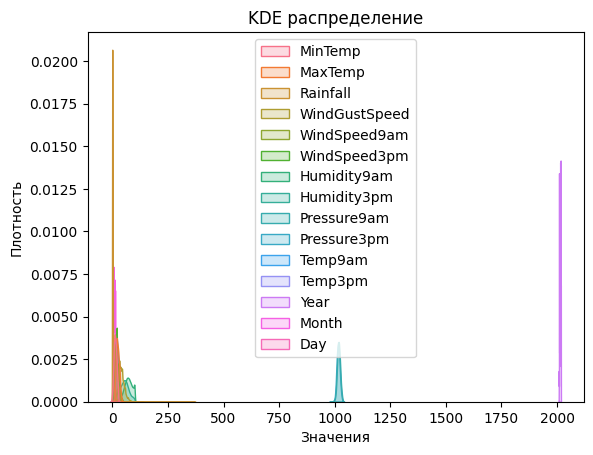

In [28]:
sns.kdeplot(df, fill=True, color='lightcoral')
plt.title('KDE распределение')
plt.xlabel('Значения')
plt.ylabel('Плотность')
plt.show()


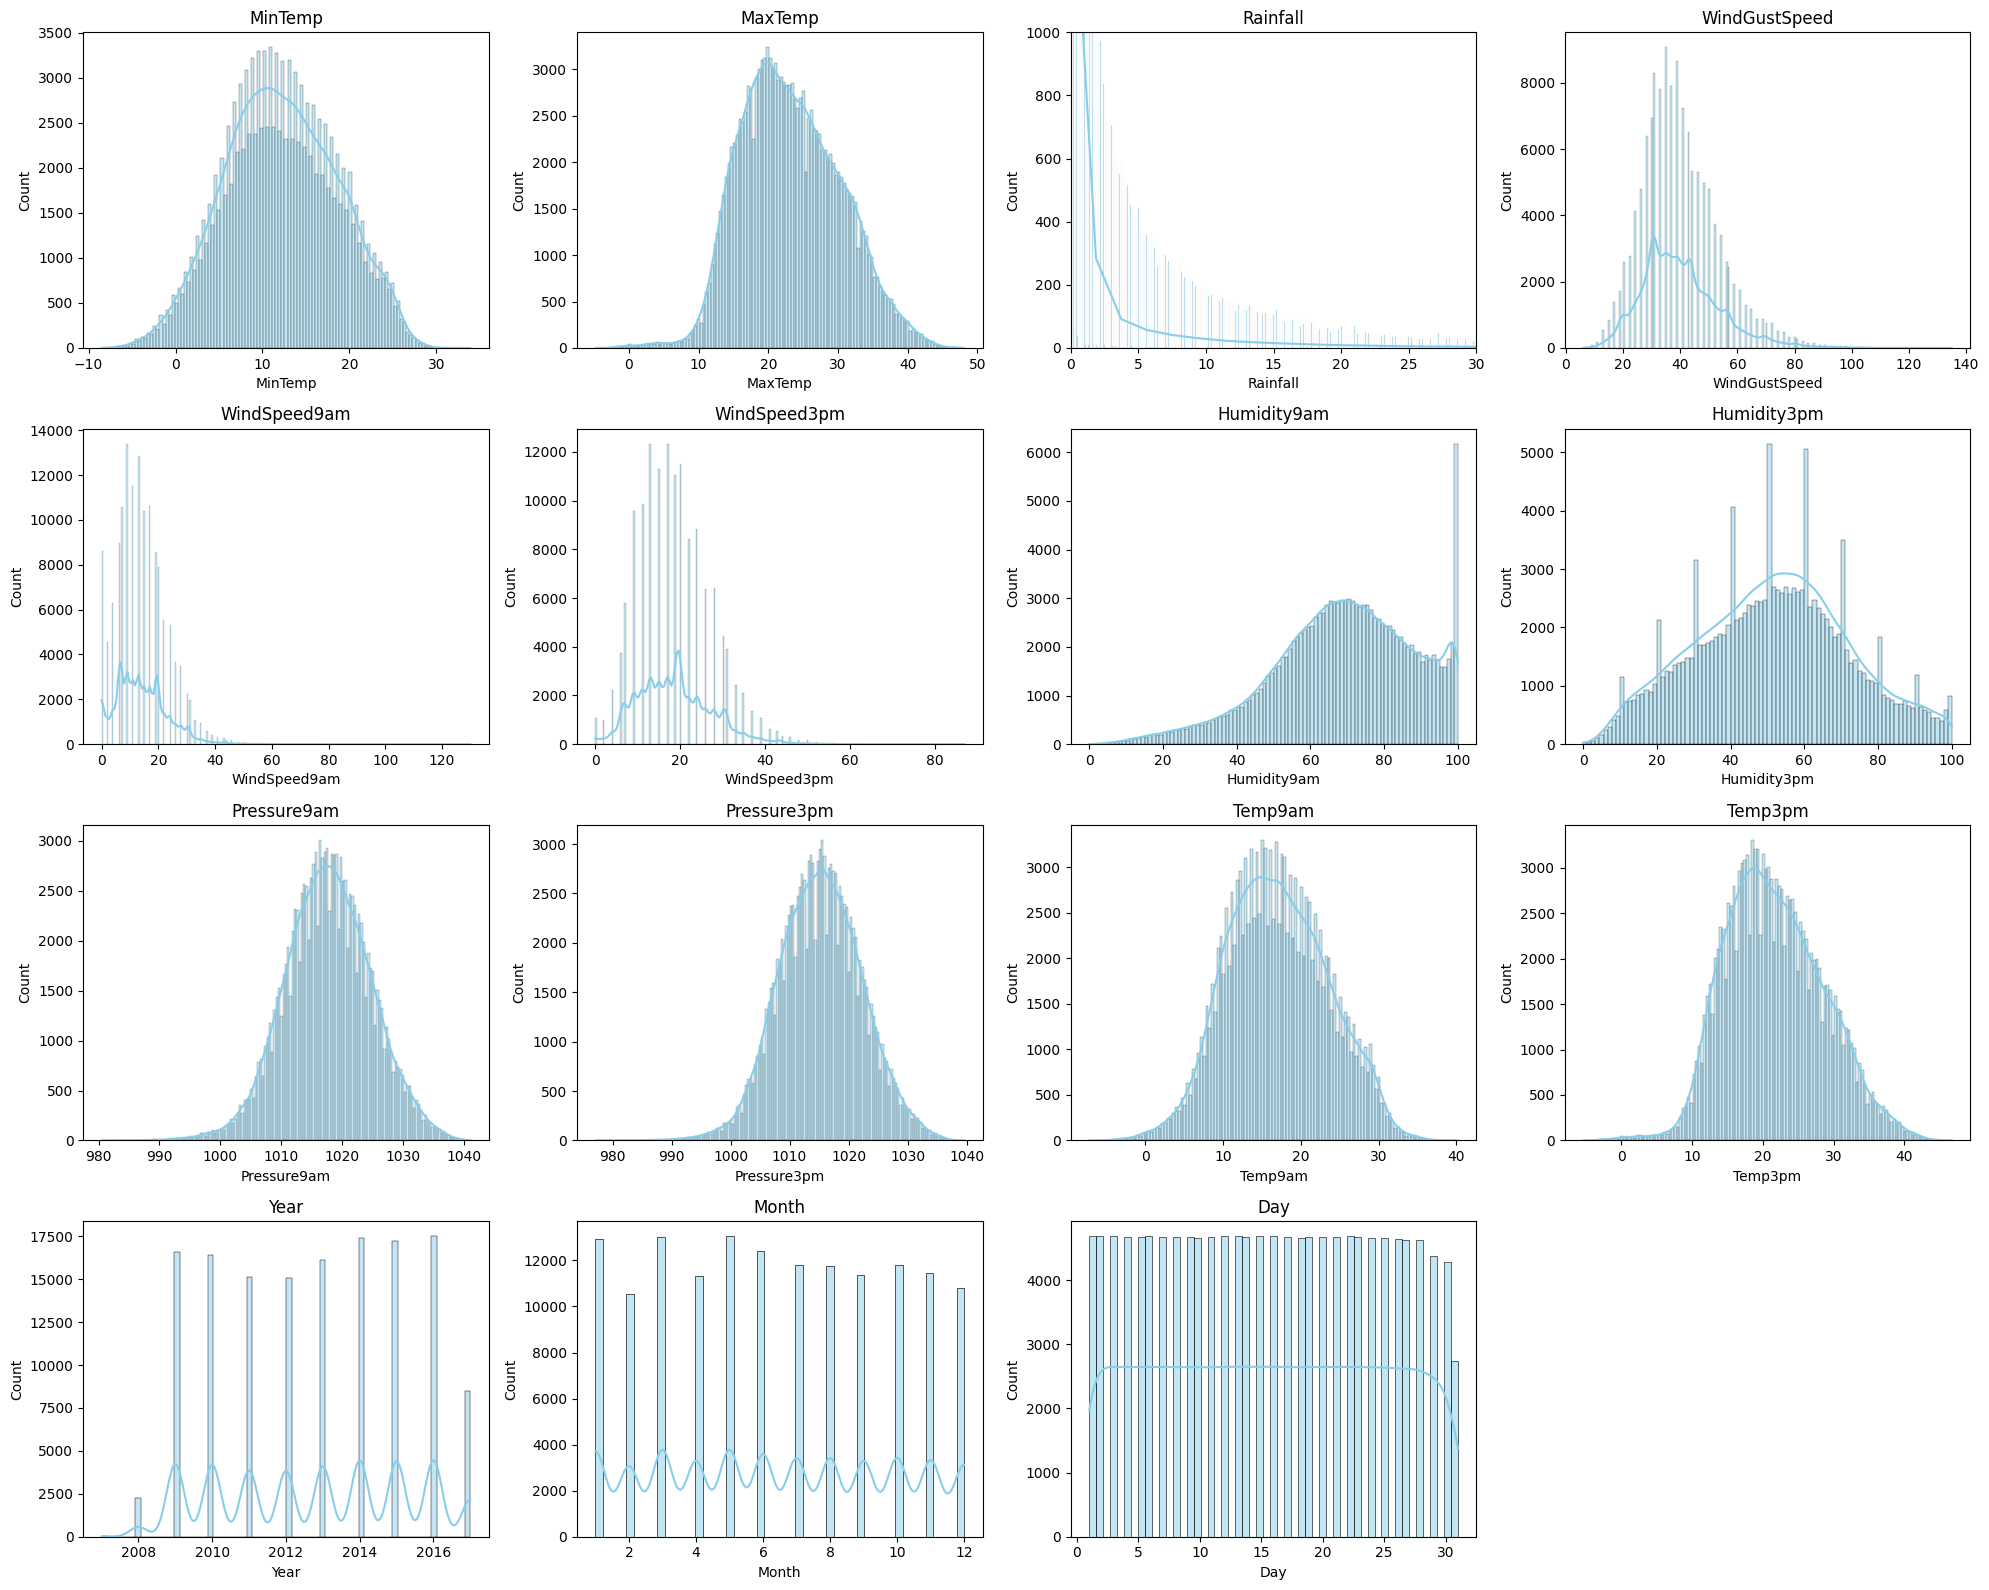

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df.select_dtypes(include='number').columns  # только числовые
n_cols = 4  # число графиков в одном ряду
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    if col == 'Rainfall':
        axes[i].set_ylim(0, 1000)  # задаём лимит через axes[i]
        axes[i].set_xlim(0, 30)
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col)

# Оставшиеся пустые графики скрываем
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
#Видим нормальное распределение у большинства признаков, у Humidity9am левое смещение, у Rainfall не нормальное распределение


C:\Users\dima2\AppData\Local\Temp\ipykernel_13544\4219826736.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


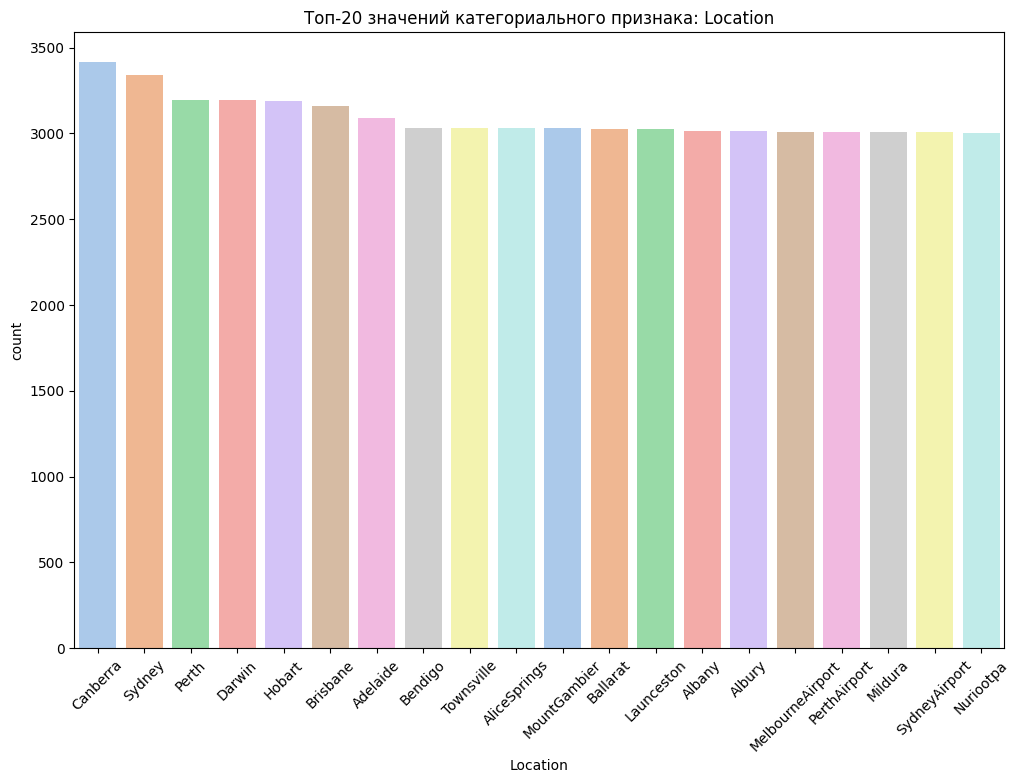

C:\Users\dima2\AppData\Local\Temp\ipykernel_13544\4219826736.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


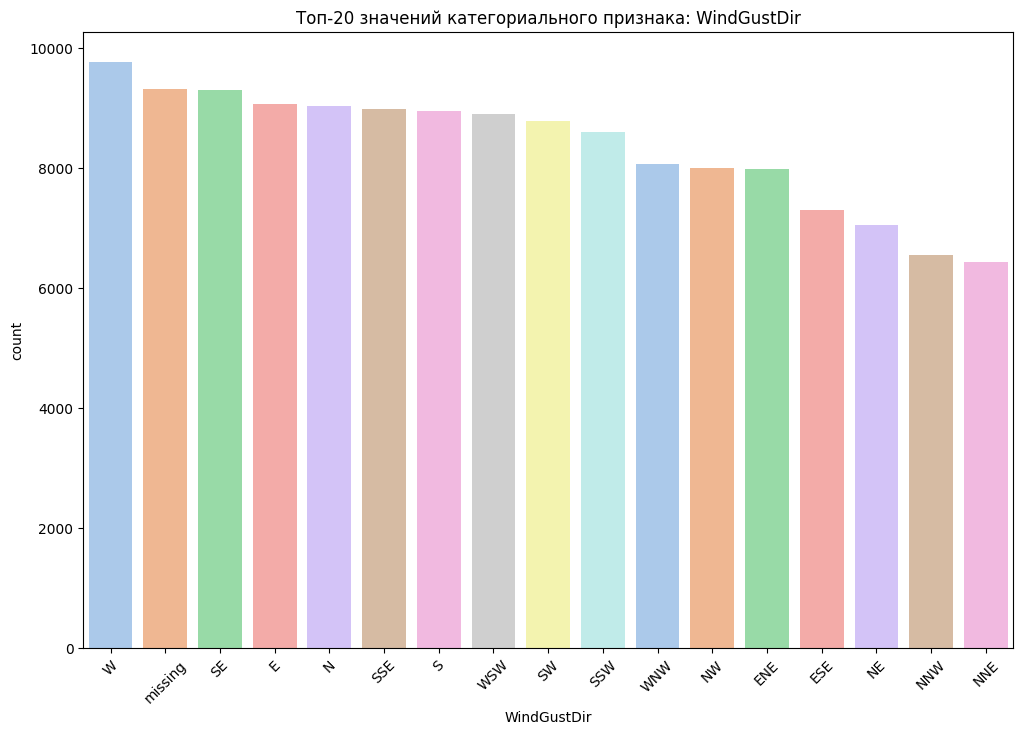

C:\Users\dima2\AppData\Local\Temp\ipykernel_13544\4219826736.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


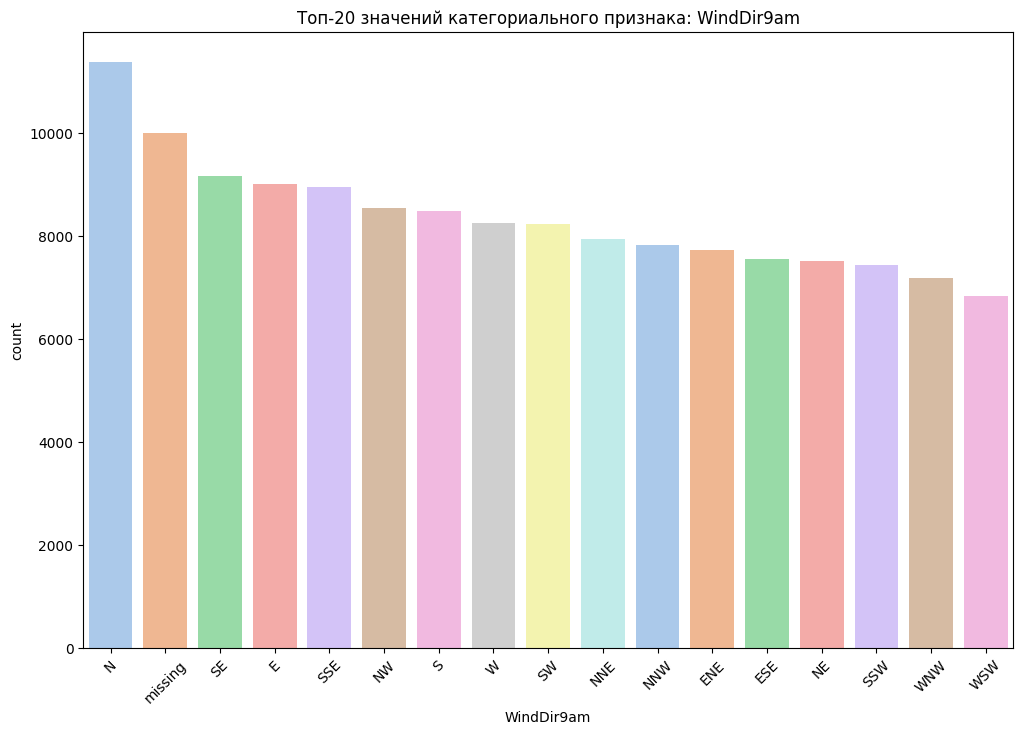

C:\Users\dima2\AppData\Local\Temp\ipykernel_13544\4219826736.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


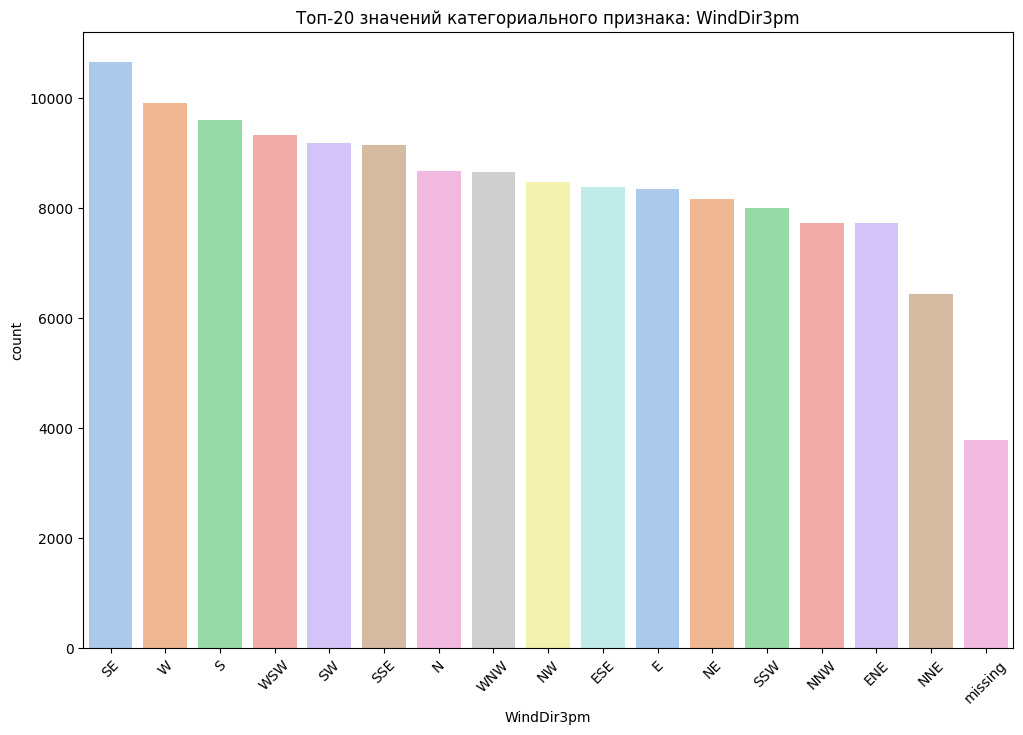

C:\Users\dima2\AppData\Local\Temp\ipykernel_13544\4219826736.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


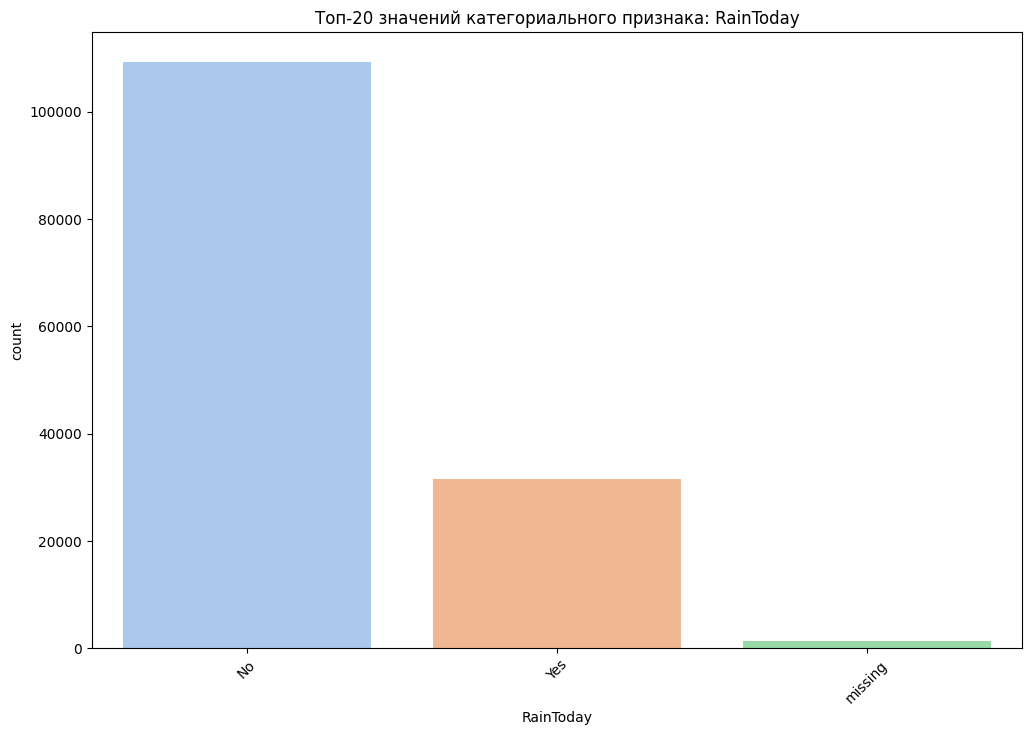

C:\Users\dima2\AppData\Local\Temp\ipykernel_13544\4219826736.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=top_values, palette='pastel')


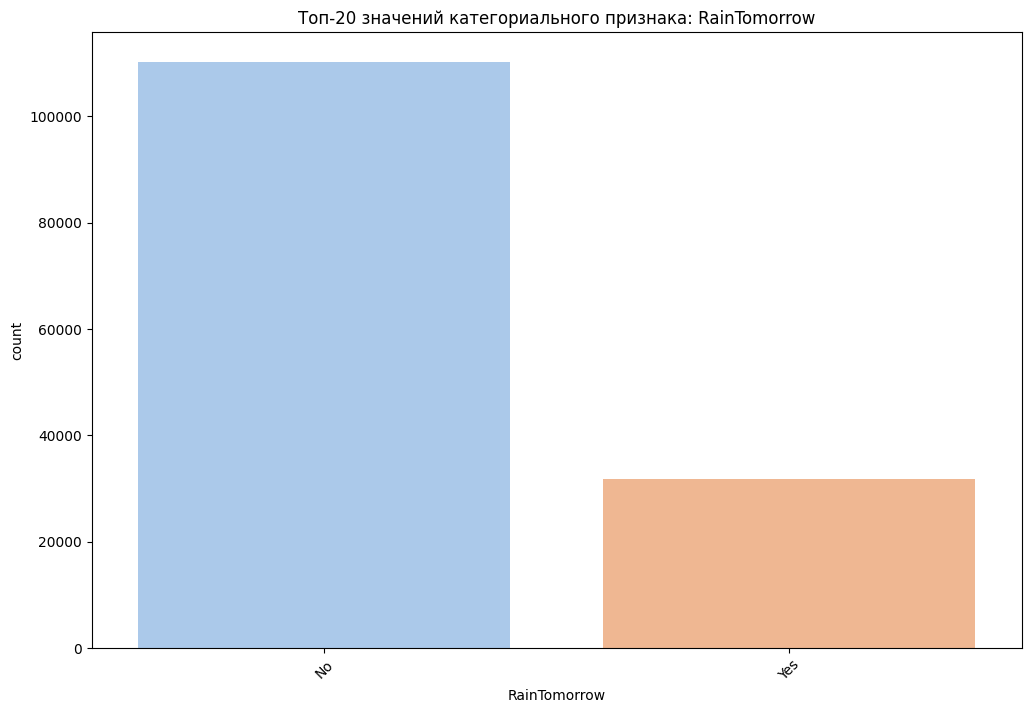

In [ ]:
#Смотрим распределения категориальных признаков
categorical_features = df.select_dtypes(include='object')
top_n = 20
for col in categorical_features:
    top_values = df[col].value_counts().nlargest(top_n).index
    plt.figure(figsize=(12,8))
    sns.countplot(x=df[col], order=top_values, palette='pastel')
    plt.title(f'Топ-{top_n} значений категориального признака: {col}')
    plt.xticks(rotation=45)
    plt.show()


In [35]:
df.drop([])

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,...,22.0,1007.7,1007.1,16.9,21.8,No,No,2008,12,1
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,...,25.0,1010.6,1007.8,17.2,24.3,No,No,2008,12,2
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,...,30.0,1007.6,1008.7,21.0,23.2,No,No,2008,12,3
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,...,16.0,1017.6,1012.8,18.1,26.5,No,No,2008,12,4
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,...,33.0,1010.8,1006.0,17.8,29.7,No,No,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,Uluru,3.5,21.8,0.0,E,31.0,ESE,E,15.0,13.0,...,27.0,1024.7,1021.2,9.4,20.9,No,No,2017,6,20
145455,Uluru,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,...,24.0,1024.6,1020.3,10.1,22.4,No,No,2017,6,21
145456,Uluru,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,...,21.0,1023.5,1019.1,10.9,24.5,No,No,2017,6,22
145457,Uluru,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,...,24.0,1021.0,1016.8,12.5,26.1,No,No,2017,6,23


In [36]:
#Удаляем пропуски в категориальных признаках
cat_features = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


#for col in cat_features:
    #X[col] = X[col].fillna('missing').astype(str)
for col in cat_features:
    df[col] = df[col].fillna('missing').astype(str)
    print(f'{col} = {df[col].unique()}')

Location = ['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
WindGustDir = ['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' 'ENE' 'SSE' 'S' 'NW' 'SE' 'ESE'
 'missing' 'E' 'SSW']
WindDir9am = ['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' 'missing' 'SSW' 'N' 'WSW' 'ESE'
 'E' 'NW' 'WNW' 'NNE']
WindDir3pm = ['WNW' 'WSW' 'E' 'NW' 'W' 'SSE' 'ESE' 'ENE' 'NNW' 'SSW' 'SW' 'SE' 'N' 'S'
 'NNE' 'missing' 'NE']
RainToday = ['No' 'Yes' 'missing']


In [23]:
new_df = df.copy()
new_df.drop('RainTomorrow', axis=1, inplace=True)


In [24]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   MaxTemp        141871 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   WindGustDir    132863 non-null  object 
 5   WindGustSpeed  132923 non-null  float64
 6   WindDir9am     132180 non-null  object 
 7   WindDir3pm     138415 non-null  object 
 8   WindSpeed9am   140845 non-null  float64
 9   WindSpeed3pm   139563 non-null  float64
 10  Humidity9am    140419 non-null  float64
 11  Humidity3pm    138583 non-null  float64
 12  Pressure9am    128179 non-null  float64
 13  Pressure3pm    128212 non-null  float64
 14  Temp9am        141289 non-null  float64
 15  Temp3pm        139467 non-null  float64
 16  RainToday      140787 non-null  object 
 17  Year           142193 non-null  in

interval columns not set, guessing: ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Year', 'Month', 'Day']


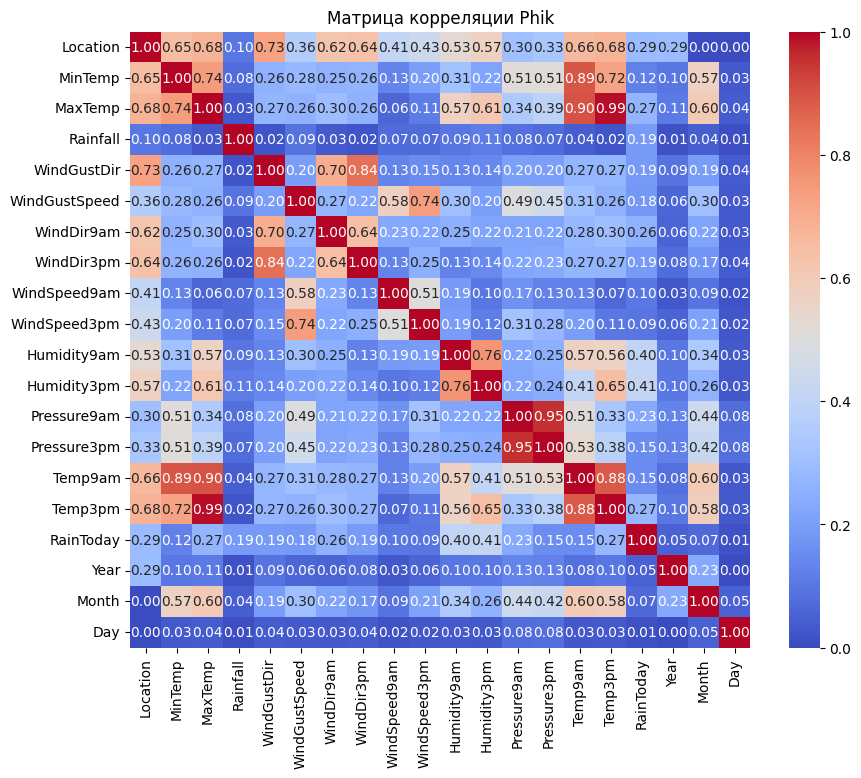

In [39]:
#Построим матрицу корреляций
phik_matrix = new_df.phik_matrix()

plt.figure(figsize=(10,8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Матрица корреляции Phik")
plt.show()



In [25]:
X = new_df.copy()
y = df['RainTomorrow']

In [26]:
X['RainToday'].value_counts()

RainToday
No     109332
Yes     31455
Name: count, dtype: int64

In [27]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   MaxTemp        141871 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   WindGustDir    132863 non-null  object 
 5   WindGustSpeed  132923 non-null  float64
 6   WindDir9am     132180 non-null  object 
 7   WindDir3pm     138415 non-null  object 
 8   WindSpeed9am   140845 non-null  float64
 9   WindSpeed3pm   139563 non-null  float64
 10  Humidity9am    140419 non-null  float64
 11  Humidity3pm    138583 non-null  float64
 12  Pressure9am    128179 non-null  float64
 13  Pressure3pm    128212 non-null  float64
 14  Temp9am        141289 non-null  float64
 15  Temp3pm        139467 non-null  float64
 16  RainToday      140787 non-null  object 
 17  Year           142193 non-null  in

In [28]:
X['RainToday'].value_counts()

RainToday
No     109332
Yes     31455
Name: count, dtype: int64

In [29]:
print(y.info())

<class 'pandas.core.series.Series'>
Index: 142193 entries, 0 to 145458
Series name: RainTomorrow
Non-Null Count   Dtype 
--------------   ----- 
142193 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB
None


In [30]:
X.isnull().sum()

Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Temp9am            904
Temp3pm           2726
RainToday         1406
Year                 0
Month                0
Day                  0
dtype: int64

In [31]:
X['RainToday'] = X['RainToday'].map({'No':0, 'Yes':1})  # сначала заменяем строки
X['RainToday'] = X['RainToday'].fillna(-1)             # пропуски заменяем на -1

print(X.dtypes)

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday        float64
Year               int32
Month              int32
Day                int32
dtype: object


In [32]:
X['RainToday'].value_counts()

RainToday
 0.0    109332
 1.0     31455
-1.0      1406
Name: count, dtype: int64

In [61]:
#Так как распределение почти всех числовых признаков нормально то заполним пропуски через mean
num_mis = num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_missing = SimpleImputer(strategy='mean')
num_trans_miss = ColumnTransformer([
    ('num', numeric_missing, num_mis)
], remainder='passthrough')


In [33]:
X['WindDir3pm'].value_counts()

WindDir3pm
SE     10663
W       9911
S       9598
WSW     9329
SW      9182
SSE     9142
N       8667
WNW     8656
NW      8468
ESE     8382
E       8342
NE      8164
SSW     8010
NNW     7733
ENE     7724
NNE     6444
Name: count, dtype: int64

In [ ]:


categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
categorical_encoder = TargetEncoder(handle_unknown='use_encoded_value',handle_missing='value')

preprocessor = ColumnTransformer(transformers=[   
    ('cat', categorical_encoder, categorical_cols)
], remainder='passthrough')

In [34]:

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_transformer = SimpleImputer(strategy='mean')

cat_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
cat_transformer = TargetEncoder(handle_unknown='use_encoded_value', handle_missing='value')

# единый ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    remainder='passthrough'
)


In [35]:
#Построим пайплайн ддя всех получившихся обработок
preprocessor_pipline = Pipeline([
    ('preprocessed', preprocessor)
])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2
)

In [37]:
X_train_preprocessed = X_train.copy()
X_test_preprocessed = X_test.copy()



In [38]:
print(X_train.columns)

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Month',
       'Day'],
      dtype='object')


In [39]:
X_train.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,Year,Month,Day
18401,NorahHead,15.1,23.9,0.0,SSW,67.0,NW,W,19.0,22.0,38.0,68.0,1001.9,1002.4,19.8,14.3,0.0,2009,10,14
127797,Walpole,9.7,14.2,7.6,WSW,50.0,WNW,W,15.0,28.0,91.0,56.0,1008.2,1007.7,11.1,13.4,1.0,2011,9,26
40012,Williamtown,13.2,25.4,0.0,ENE,30.0,W,E,6.0,17.0,79.0,63.0,1025.2,1021.5,21.2,24.0,0.0,2010,4,20
130914,Hobart,7.6,14.8,0.0,WNW,94.0,WNW,WNW,30.0,35.0,52.0,45.0,1004.6,1001.4,11.1,12.9,0.0,2011,7,12
41742,Williamtown,12.9,22.2,0.0,S,37.0,SW,SSE,15.0,20.0,69.0,52.0,1023.0,1021.2,18.8,20.6,0.0,2015,4,13


In [40]:
X_test.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,Year,Month,Day
57760,Ballarat,7.1,13.0,8.8,N,41.0,N,WNW,24.0,22.0,100.0,98.0,1001.7,1005.4,8.6,11.5,1.0,2016,6,9
127128,Walpole,13.2,18.3,0.0,E,48.0,ESE,ESE,24.0,20.0,73.0,73.0,1027.6,1023.8,14.2,17.0,0.0,2009,10,24
119994,PerthAirport,9.2,22.7,0.0,ENE,52.0,ENE,ESE,26.0,20.0,45.0,25.0,1030.1,1025.9,15.1,22.5,0.0,2015,9,21
7088,Cobar,15.3,26.1,0.0,E,44.0,E,NE,24.0,19.0,48.0,40.0,1013.2,1009.8,17.5,24.3,0.0,2011,12,6
62992,Sale,11.9,31.8,0.0,NW,72.0,E,N,6.0,19.0,89.0,25.0,1006.7,1001.0,16.2,27.4,0.0,2014,3,15


In [41]:
print(type(X_train))  # должно быть <class 'pandas.core.frame.DataFrame'>


<class 'pandas.core.frame.DataFrame'>


In [46]:
# === 5. Трансформация ===
X_train_transformed = preprocessor_pipline.fit_transform(X_train, y_train)
X_test_transformed = preprocessor_pipline.transform(X_test)

# === 6. Сохраняем имена колонок ===
# Числовые колонки остаются как есть
num_features = num_cols

# Категориальные — через TargetEncoder новые колонки соответствуют старым
cat_features = cat_cols

# Объединяем все колонки
all_features = list(num_features) + list(cat_features)
transformed_columns = (num_cols + cat_cols +
                       [c for c in X_train.columns if c not in num_cols + cat_cols])

# Преобразуем NumPy массив обратно в DataFrame
X_train_preprocessed = pd.DataFrame(X_train_transformed, index=X_train.index, columns=transformed_columns)
X_test_preprocessed = pd.DataFrame(X_test_transformed, index=X_test.index, columns=transformed_columns)

# === 7. Проверка ===
print(X_train_preprocessed.head().to_string())
print(X_test_preprocessed.head().to_string())

        MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  Location  WindGustDir  WindDir9am  WindDir3pm    Year  Month   Day
18401      15.1     23.9       0.0           67.0          19.0          22.0         38.0         68.0       1001.9       1002.4     19.8     14.3        0.0  0.270073     0.221290    0.284204    0.256413  2009.0   10.0  14.0
127797      9.7     14.2       7.6           50.0          15.0          28.0         91.0         56.0       1008.2       1007.7     11.1     13.4        1.0  0.342047     0.233484    0.269544    0.256413  2011.0    9.0  26.0
40012      13.2     25.4       0.0           30.0           6.0          17.0         79.0         63.0       1025.2       1021.5     21.2     24.0        0.0  0.275455     0.160309    0.262196    0.169348  2010.0    4.0  20.0
130914      7.6     14.8       0.0           94.0          30.0          35.0         52.0  

In [47]:
X_test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28439 entries, 57760 to 44133
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        28439 non-null  float64
 1   MaxTemp        28439 non-null  float64
 2   Rainfall       28439 non-null  float64
 3   WindGustSpeed  28439 non-null  float64
 4   WindSpeed9am   28439 non-null  float64
 5   WindSpeed3pm   28439 non-null  float64
 6   Humidity9am    28439 non-null  float64
 7   Humidity3pm    28439 non-null  float64
 8   Pressure9am    28439 non-null  float64
 9   Pressure3pm    28439 non-null  float64
 10  Temp9am        28439 non-null  float64
 11  Temp3pm        28439 non-null  float64
 12  RainToday      28439 non-null  float64
 13  Location       28439 non-null  float64
 14  WindGustDir    28439 non-null  float64
 15  WindDir9am     28439 non-null  float64
 16  WindDir3pm     28439 non-null  float64
 17  Year           28439 non-null  float64
 18  Month  

In [48]:
X_test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28439 entries, 57760 to 44133
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        28439 non-null  float64
 1   MaxTemp        28439 non-null  float64
 2   Rainfall       28439 non-null  float64
 3   WindGustSpeed  28439 non-null  float64
 4   WindSpeed9am   28439 non-null  float64
 5   WindSpeed3pm   28439 non-null  float64
 6   Humidity9am    28439 non-null  float64
 7   Humidity3pm    28439 non-null  float64
 8   Pressure9am    28439 non-null  float64
 9   Pressure3pm    28439 non-null  float64
 10  Temp9am        28439 non-null  float64
 11  Temp3pm        28439 non-null  float64
 12  RainToday      28439 non-null  float64
 13  Location       28439 non-null  float64
 14  WindGustDir    28439 non-null  float64
 15  WindDir9am     28439 non-null  float64
 16  WindDir3pm     28439 non-null  float64
 17  Year           28439 non-null  float64
 18  Month  

In [49]:
y_train.value_counts()

RainTomorrow
No     88218
Yes    25536
Name: count, dtype: int64

In [50]:
y_train = y_train.map({'No': 0, 'Yes': 1})
y_test = y_test.map({'No': 0, 'Yes': 1})


In [51]:
############################################### BASELINE DUMMY CLASSIFIER##########################################################
dummy_classfier = DummyClassifier(random_state=42, strategy='most_frequent')
dummy_classfier.fit(X_train_preprocessed, y_train)

y_pred = dummy_classfier.predict(X_test_preprocessed)
y_probs = dummy_classfier.predict_proba(X_test_preprocessed)[:, 1]

# Считаем метрики для модели и выводим графики
dummy_classifier_metrics = classification_metrics(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name='DUMMY_CLASSIFIER'
)
print(dummy_classifier_metrics)

=== DUMMY_CLASSIFIER ===
Accuracy:  0.7770
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
ROC AUC:   0.5000
{'DUMMY_CLASSIFIER_Accuracy': 0.7770315411934315, 'DUMMY_CLASSIFIER_Precision': 0.0, 'DUMMY_CLASSIFIER_Recall': 0.0, 'DUMMY_CLASSIFIER_F1': 0.0, 'DUMMY_CLASSIFIER_ROC_AUC': np.float64(0.5)}


c:\Users\dima2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
############################################### BASELINE LOG_REG CLASSIFIER##########################################################
LogReg_classfier = LogisticRegression(random_state=42)
LogReg_classfier.fit(X_train_preprocessed, y_train)

y_pred = LogReg_classfier.predict(X_test_preprocessed)
y_probs = LogReg_classfier.predict_proba(X_test_preprocessed)[:, 1]

# Считаем метрики для модели и выводим графики
LogReg_classifier_metrics = classification_metrics(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name='LOG_REG_CLASSIFIER'
)
print(LogReg_classifier_metrics)

=== LOG_REG_CLASSIFIER ===
Accuracy:  0.8351
Precision: 0.6987
Recall:    0.4580
F1 Score:  0.5533
ROC AUC:   0.8439
{'LOG_REG_CLASSIFIER_Accuracy': 0.8351207848377229, 'LOG_REG_CLASSIFIER_Precision': 0.6987487969201155, 'LOG_REG_CLASSIFIER_Recall': 0.45797192871786785, 'LOG_REG_CLASSIFIER_F1': 0.5533009431266076, 'LOG_REG_CLASSIFIER_ROC_AUC': np.float64(0.8439431658739583)}


c:\Users\dima2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
############################################### BASELINE TREE CLASSIFIER##########################################################
Tree_classfier = DecisionTreeClassifier(random_state=42, max_depth=10)
Tree_classfier.fit(X_train_preprocessed, y_train)

y_pred = Tree_classfier.predict(X_test_preprocessed)
y_probs = Tree_classfier.predict_proba(X_test_preprocessed)[:, 1]

# Считаем метрики для модели и выводим графики
Tree_classifier_metrics = classification_metrics(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name='TREE_CLASSIFIER'
)
print(Tree_classifier_metrics)

=== TREE_CLASSIFIER ===
Accuracy:  0.8377
Precision: 0.6852
Recall:    0.5029
F1 Score:  0.5801
ROC AUC:   0.8342
{'TREE_CLASSIFIER_Accuracy': 0.8376525194275467, 'TREE_CLASSIFIER_Precision': 0.6852170176192522, 'TREE_CLASSIFIER_Recall': 0.5029175208957578, 'TREE_CLASSIFIER_F1': 0.5800818553888131, 'TREE_CLASSIFIER_ROC_AUC': np.float64(0.834242075082696)}


In [54]:
importances = pd.DataFrame({
    'Feature': X_train_preprocessed.columns,
    'Importance': Tree_classfier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances)

          Feature  Importance
7     Humidity3pm    0.571146
2        Rainfall    0.097826
3   WindGustSpeed    0.084038
9     Pressure3pm    0.069336
13       Location    0.021955
6     Humidity9am    0.018613
16     WindDir3pm    0.018215
0         MinTemp    0.017586
1         MaxTemp    0.017202
11        Temp3pm    0.014782
8     Pressure9am    0.011806
10        Temp9am    0.010919
5    WindSpeed3pm    0.008807
4    WindSpeed9am    0.006816
18          Month    0.006542
15     WindDir9am    0.006388
14    WindGustDir    0.005891
19            Day    0.005552
12      RainToday    0.004405
17           Year    0.002173


In [ ]:
############################################### BASELINE RANDOM_FOREST CLASSIFIER##########################################################
random_forest_classfier = RandomForestClassifier(random_state=42)
random_forest_classfier.fit(X_train_preprocessed, y_train)

y_pred = random_forest_classfier.predict(X_test_preprocessed)
y_probs = random_forest_classfier.predict_proba(X_test_preprocessed)[:, 1]

# Считаем метрики для модели и выводим графики
random_forest_classifier_metrics = classification_metrics(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name='RANDOM_FOREST_CLASSIFIER'
)
print(random_forest_classifier_metrics)

=== RANDOM_FOREST_CLASSIFIER ===
Accuracy:  0.8522
Precision: 0.7749
Recall:    0.4750
F1 Score:  0.5890
ROC AUC:   0.8800
{'RANDOM_FOREST_CLASSIFIER_Accuracy': 0.8521748303386195, 'RANDOM_FOREST_CLASSIFIER_Precision': 0.7748906611782866, 'RANDOM_FOREST_CLASSIFIER_Recall': 0.4750039425958051, 'RANDOM_FOREST_CLASSIFIER_F1': 0.5889714509190458, 'RANDOM_FOREST_CLASSIFIER_ROC_AUC': np.float64(0.8799874229445359)}


In [56]:
importances = pd.DataFrame({
    'Feature': X_train_preprocessed.columns,
    'Importance': random_forest_classfier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances)

          Feature  Importance
7     Humidity3pm    0.189414
9     Pressure3pm    0.065064
2        Rainfall    0.064043
6     Humidity9am    0.061938
3   WindGustSpeed    0.056941
8     Pressure9am    0.056118
11        Temp3pm    0.052440
0         MinTemp    0.049124
1         MaxTemp    0.047233
10        Temp9am    0.046098
13       Location    0.041133
19            Day    0.036978
5    WindSpeed3pm    0.034720
4    WindSpeed9am    0.032504
16     WindDir3pm    0.030459
15     WindDir9am    0.029742
14    WindGustDir    0.029125
17           Year    0.026229
18          Month    0.026045
12      RainToday    0.024652


In [57]:
############################################### BASELINE GRADIENT_BOOSTING CLASSIFIER##########################################################
gradient_boosting_classfier =GradientBoostingClassifier(random_state=42)
gradient_boosting_classfier.fit(X_train_preprocessed, y_train)

y_pred =gradient_boosting_classfier.predict(X_test_preprocessed)
y_probs = gradient_boosting_classfier.predict_proba(X_test_preprocessed)[:, 1]

# Считаем метрики для модели и выводим графики
gradient_boosting_classifier_metrics = classification_metrics(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name='GRADIENT_BOOSTING_CLASSIFIER'
)
print(gradient_boosting_classifier_metrics)

=== GRADIENT_BOOSTING_CLASSIFIER ===
Accuracy:  0.8463
Precision: 0.7339
Recall:    0.4875
F1 Score:  0.5858
ROC AUC:   0.8595
{'GRADIENT_BOOSTING_CLASSIFIER_Accuracy': 0.8463026126094447, 'GRADIENT_BOOSTING_CLASSIFIER_Precision': 0.7338556505223172, 'GRADIENT_BOOSTING_CLASSIFIER_Recall': 0.4874625453398518, 'GRADIENT_BOOSTING_CLASSIFIER_F1': 0.5858049843646357, 'GRADIENT_BOOSTING_CLASSIFIER_ROC_AUC': np.float64(0.8595295577217507)}


In [177]:
importances = pd.DataFrame({
    'Feature': X_train_preprocessed.columns,
    'Importance': gradient_boosting_classfier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances)

          Feature  Importance
7     Humidity3pm    0.650135
2        Rainfall    0.095920
9     Pressure3pm    0.083283
3   WindGustSpeed    0.082138
11        Temp3pm    0.013389
15       Location    0.013206
6     Humidity9am    0.011563
10        Temp9am    0.008654
0         MinTemp    0.008262
18     WindDir3pm    0.006265
5    WindSpeed3pm    0.005204
17     WindDir9am    0.004884
19      RainToday    0.004646
1         MaxTemp    0.004570
13          Month    0.002987
16    WindGustDir    0.001903
4    WindSpeed9am    0.001786
8     Pressure9am    0.000850
12           Year    0.000338
14            Day    0.000017


In [59]:
models = [
    ('LogisticRegression', LogisticRegression(random_state=SEED)),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=10)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=SEED))
]

In [60]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [61]:
initial_metrics = evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.8377
Precision: 0.7872
Recall:    0.7023
F1 Score:  0.7293
ROC AUC:   0.8481

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8393
Precision: 0.7848
Recall:    0.7137
F1 Score:  0.7382
ROC AUC:   0.8390

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8560
Precision: 0.8206
Recall:    0.7328
F1 Score:  0.7624
ROC AUC:   0.8833

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8484
Precision: 0.8064
Recall:    0.7208
F1 Score:  0.7491
ROC AUC:   0.8668

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8560     0.8206  0.7328 0.7624   0.8833
GradientBoostingClassifier    0.8484     0.8064  0.7208 0.7491   0.8668
LogisticRegression            0.8377     0.7872  0.7023 0.7293   0.8481
DecisionTreeClassifier        0.8393     0.7848  0.7137 0.7382   0.8390


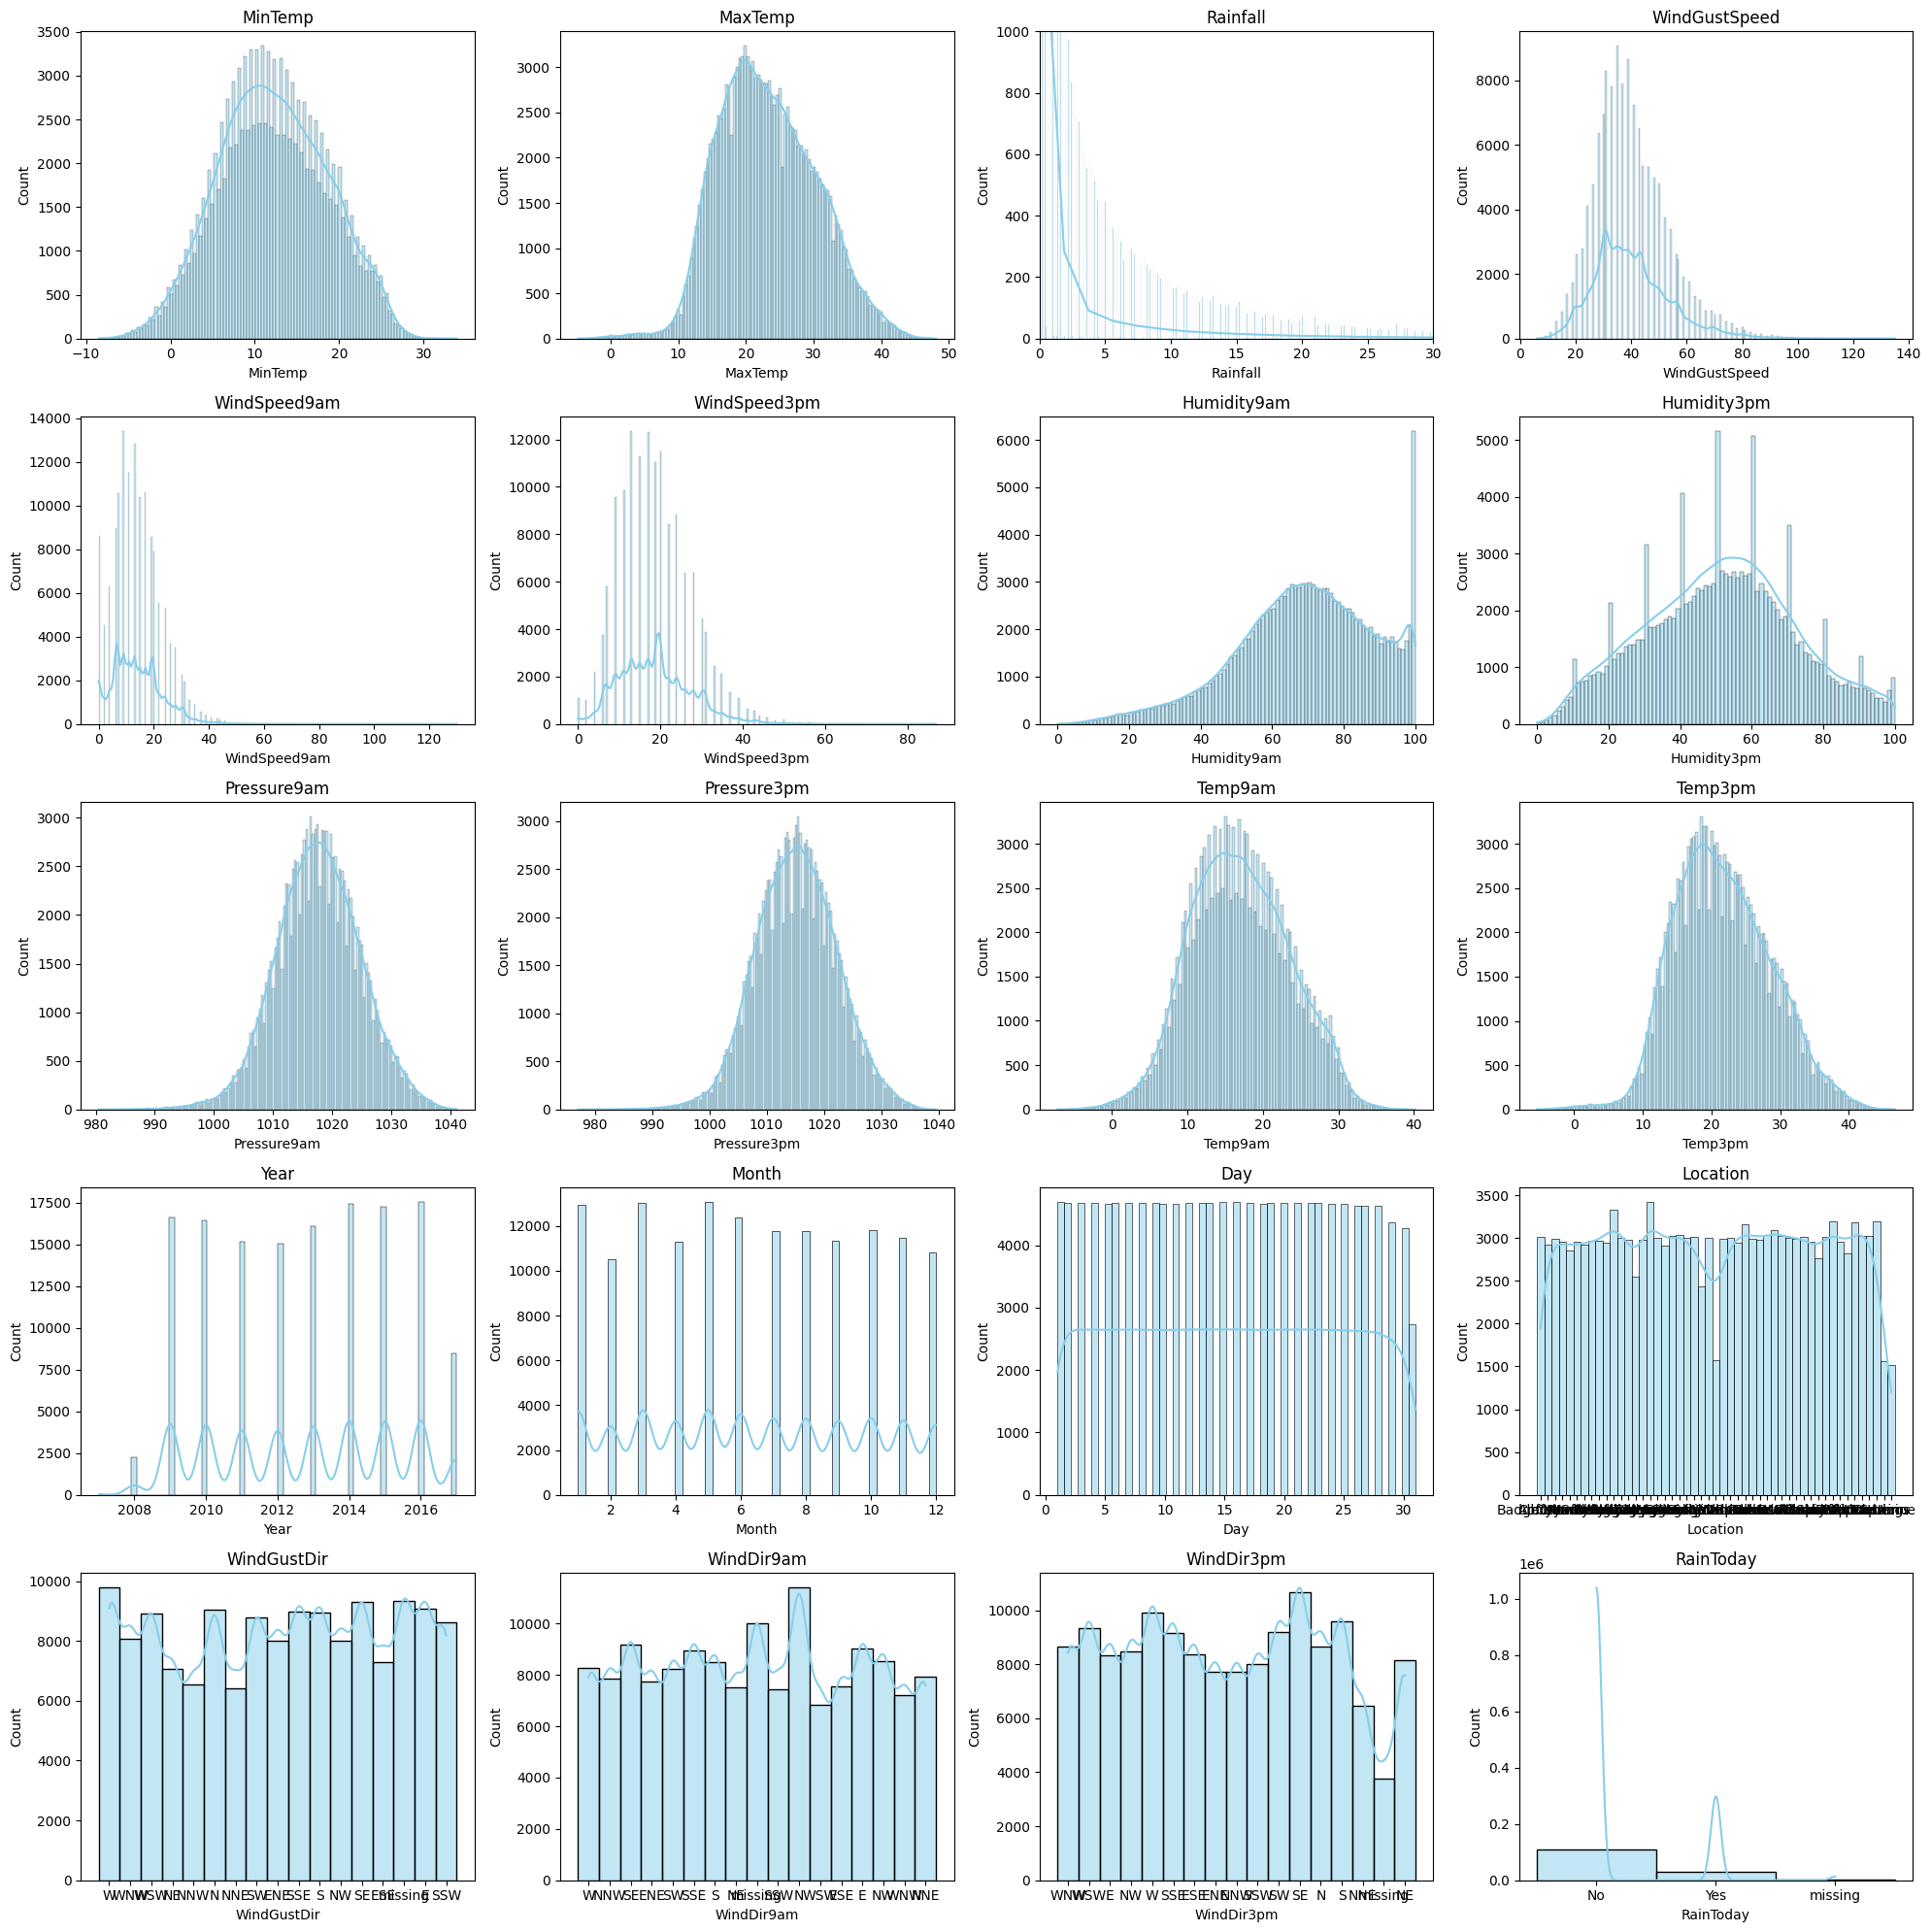

In [223]:
num_cols =X_train_preprocessed.select_dtypes(include='number').columns  # только числовые
n_cols = 4  # число графиков в одном ряду
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    if col == 'Rainfall':
        axes[i].set_ylim(0, 1000)  # задаём лимит через axes[i]
        axes[i].set_xlim(0, 30)
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col)

# Оставшиеся пустые графики скрываем
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
#Видим нормальное распределение у большинства признаков


In [62]:
X_train_preprocessed_skewed = X_train_preprocessed.copy()

In [63]:
#Добавим колонки для признаков у которых не нормальное распределение
X_train_preprocessed_skewed['Raifall_Log'] = np.log1p(X_train_preprocessed_skewed['Rainfall'])
X_train_preprocessed_skewed['WindSpeed9am_Log'] = np.log1p(X_train_preprocessed_skewed['WindSpeed9am'])
X_train_preprocessed_skewed['Humidity9am_square']=X_train_preprocessed_skewed['Humidity9am']**2

In [64]:
log_metrics = evaluate_models_cv(
    models=models,
    X=X_train_preprocessed_skewed,
    y=y_train,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.8386
Precision: 0.7889
Recall:    0.7044
F1 Score:  0.7314
ROC AUC:   0.8485

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8366
Precision: 0.7801
Recall:    0.7095
F1 Score:  0.7337
ROC AUC:   0.8353

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8528
Precision: 0.8156
Recall:    0.7273
F1 Score:  0.7567
ROC AUC:   0.8798

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8480
Precision: 0.8053
Recall:    0.7214
F1 Score:  0.7494
ROC AUC:   0.8677

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8528     0.8156  0.7273 0.7567   0.8798
GradientBoostingClassifier    0.8480     0.8053  0.7214 0.7494   0.8677
LogisticRegression            0.8386     0.7889  0.7044 0.7314   0.8485
DecisionTreeClassifier        0.8366     0.7801  0.7095 0.7337   0.8353



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0032    -0.0051 -0.0055 -0.0058  -0.0035
GradientBoostingClassifier   -0.0003    -0.0011  0.0006  0.0003   0.0009
LogisticRegression            0.0008     0.0017  0.0021  0.0021   0.0004
DecisionTreeClassifier       -0.0027    -0.0047 -0.0042 -0.0045  -0.0037


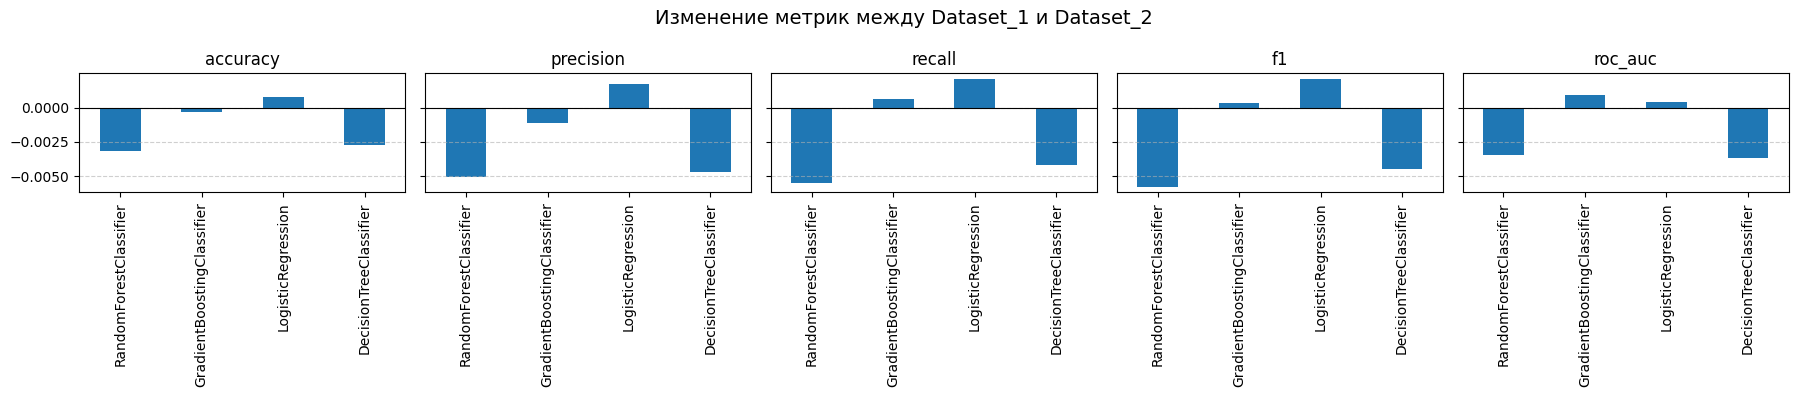

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0032,-0.0051,-0.0055,-0.0058,-0.0035
GradientBoostingClassifier,-0.0003,-0.0011,0.0006,0.0003,0.0009
LogisticRegression,0.0008,0.0017,0.0021,0.0021,0.0004
DecisionTreeClassifier,-0.0027,-0.0047,-0.0042,-0.0045,-0.0037


In [65]:
compare_datasets_results(initial_metrics, log_metrics)#Изменений почти нет

In [66]:
X_train_preprocessed_skewed_delete = X_train_preprocessed_skewed.copy()
X_train_preprocessed_skewed_delete.drop(['Rainfall', 'WindSpeed9am', 'Humidity9am'], axis=1, inplace=True)


In [67]:
log_metrics_delete =evaluate_models_cv(
    models=models,
    X=X_train_preprocessed_skewed_delete,
    y=y_train,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.8382
Precision: 0.7891
Recall:    0.7025
F1 Score:  0.7298
ROC AUC:   0.8489

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8364
Precision: 0.7797
Recall:    0.7093
F1 Score:  0.7334
ROC AUC:   0.8351

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8538
Precision: 0.8171
Recall:    0.7293
F1 Score:  0.7587
ROC AUC:   0.8822

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8480
Precision: 0.8053
Recall:    0.7214
F1 Score:  0.7494
ROC AUC:   0.8677

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8538     0.8171  0.7293 0.7587   0.8822
GradientBoostingClassifier    0.8480     0.8053  0.7214 0.7494   0.8677
LogisticRegression            0.8382     0.7891  0.7025 0.7298   0.8489
DecisionTreeClassifier        0.8364     0.7797  0.7093 0.7334   0.8351



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0022    -0.0035 -0.0035 -0.0037  -0.0011
GradientBoostingClassifier   -0.0003    -0.0011  0.0006  0.0003   0.0009
LogisticRegression            0.0005     0.0019  0.0002  0.0006   0.0008
DecisionTreeClassifier       -0.0029    -0.0051 -0.0044 -0.0048  -0.0039


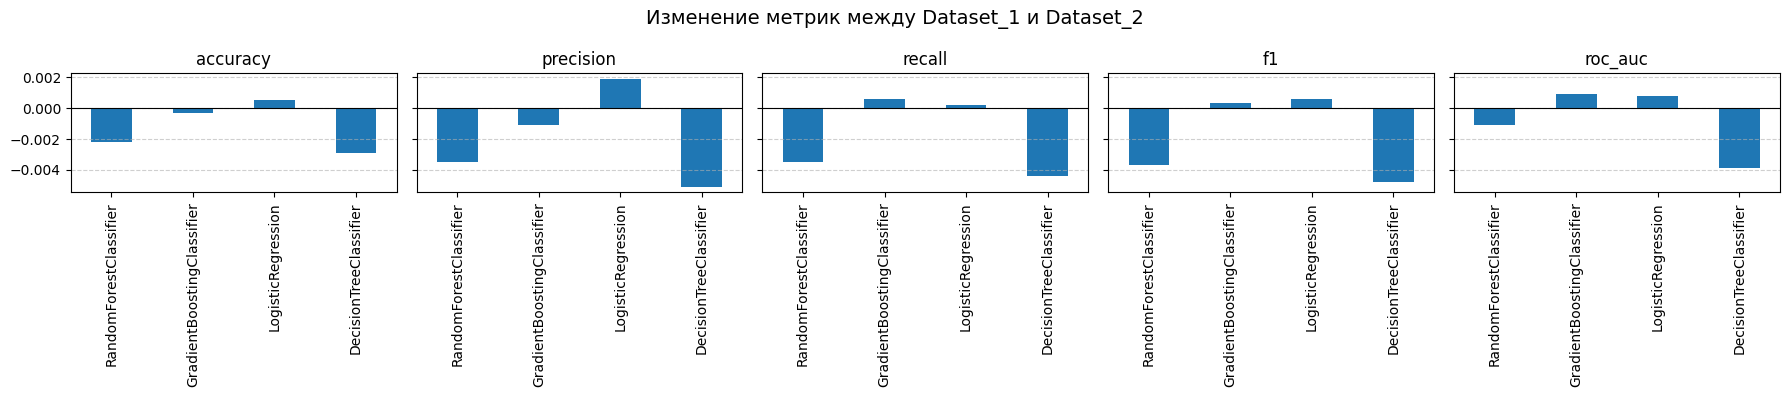

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0022,-0.0035,-0.0035,-0.0037,-0.0011
GradientBoostingClassifier,-0.0003,-0.0011,0.0006,0.0003,0.0009
LogisticRegression,0.0005,0.0019,0.0002,0.0006,0.0008
DecisionTreeClassifier,-0.0029,-0.0051,-0.0044,-0.0048,-0.0039


In [ ]:
compare_datasets_results(initial_metrics, log_metrics_delete)
#Видим что при удалении результаты только ухудшились у всех кроме лин рег

In [69]:
X_test_preprocessed.head(10)

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,Location,WindGustDir,WindDir9am,WindDir3pm,Year,Month,Day
57760,7.1,13.0,8.8,41.0,24.0,22.0,100.0,98.0,1001.7,1005.4,8.6,11.5,1.0,0.257155,0.271423,0.305488,0.278212,2016.0,6.0,9.0
127128,13.2,18.3,0.0,48.0,24.0,20.0,73.0,73.0,1027.6,1023.8,14.2,17.0,0.0,0.342047,0.148189,0.146086,0.169476,2009.0,10.0,24.0
119994,9.2,22.7,0.0,52.0,26.0,20.0,45.0,25.0,1030.1,1025.9,15.1,22.5,0.0,0.190319,0.160309,0.175073,0.169476,2015.0,9.0,21.0
7088,15.3,26.1,0.0,44.0,24.0,19.0,48.0,40.0,1013.2,1009.8,17.5,24.3,0.0,0.124005,0.148189,0.144023,0.185697,2011.0,12.0,6.0
62992,11.9,31.8,0.0,72.0,6.0,19.0,89.0,25.0,1006.7,1001.0,16.2,27.4,0.0,0.220974,0.286366,0.144023,0.277649,2014.0,3.0,15.0
28722,2.4,19.0,0.0,17.0,0.0,13.0,100.0,56.0,1024.9,1020.5,5.8,18.8,0.0,0.192340,0.189099,0.191762,0.180413,2013.0,7.0,3.0
134837,15.6,32.7,0.0,31.0,4.0,15.0,78.0,33.0,1014.2,1011.7,20.3,32.0,0.0,0.230832,0.281434,0.272612,0.282580,2014.0,2.0,8.0
57446,-1.1,9.0,2.8,61.0,6.0,31.0,100.0,55.0,1021.7,1017.1,2.5,8.6,1.0,0.257155,0.271423,0.272612,0.277649,2015.0,7.0,31.0
70481,11.9,31.8,0.0,30.0,11.0,11.0,36.0,10.0,1021.9,1019.2,15.4,30.9,0.0,0.103731,0.148189,0.179214,0.190762,2009.0,3.0,30.0
14244,19.1,32.6,0.0,61.0,39.0,19.0,56.0,34.0,1014.3,1009.7,22.2,30.7,0.0,0.139257,0.227754,0.272612,0.277649,2015.0,3.0,17.0


In [ ]:
#Добавляем разницу между мин макс температурой и разницу по времени у других признаков
X_train_preprocessed_diff = X_train_preprocessed.copy()
X_train_preprocessed_diff['Temp_diff'] = X_train_preprocessed_diff['Temp3pm'] - X_train_preprocessed_diff['Temp9am']
X_train_preprocessed_diff['Humidity_diff'] = X_train_preprocessed_diff['Humidity3pm'] - X_train_preprocessed_diff['Humidity9am']
X_train_preprocessed_diff['Pressure_diff'] = X_train_preprocessed_diff['Pressure3pm'] - X_train_preprocessed_diff['Pressure3pm']
X_train_preprocessed_diff['Wind_diff'] = X_train_preprocessed_diff['WindSpeed3pm'] - X_train_preprocessed_diff['WindSpeed9am']
X_train_preprocessed_diff['Max_Min_Temp_diff'] = X_train_preprocessed_diff['MaxTemp']-X_train_preprocessed_diff['MinTemp']


In [71]:
Diff_metrics =evaluate_models_cv(
    models=models,
    X=X_train_preprocessed_diff,
    y=y_train,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.8384
Precision: 0.7887
Recall:    0.7040
F1 Score:  0.7310
ROC AUC:   0.8492

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8365
Precision: 0.7782
Recall:    0.7126
F1 Score:  0.7357
ROC AUC:   0.8350

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8535
Precision: 0.8174
Recall:    0.7277
F1 Score:  0.7574
ROC AUC:   0.8796

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8484
Precision: 0.8061
Recall:    0.7219
F1 Score:  0.7500
ROC AUC:   0.8679

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8535     0.8174  0.7277 0.7574   0.8796
GradientBoostingClassifier    0.8484     0.8061  0.7219 0.7500   0.8679
LogisticRegression            0.8384     0.7887  0.7040 0.7310   0.8492
DecisionTreeClassifier        0.8365     0.7782  0.7126 0.7357   0.8350



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0027    -0.0040 -0.0048 -0.0049  -0.0032
GradientBoostingClassifier    0.0009     0.0018  0.0019  0.0020   0.0018
LogisticRegression            0.0007     0.0022  0.0006  0.0010   0.0008
DecisionTreeClassifier       -0.0007    -0.0014 -0.0002 -0.0005  -0.0056


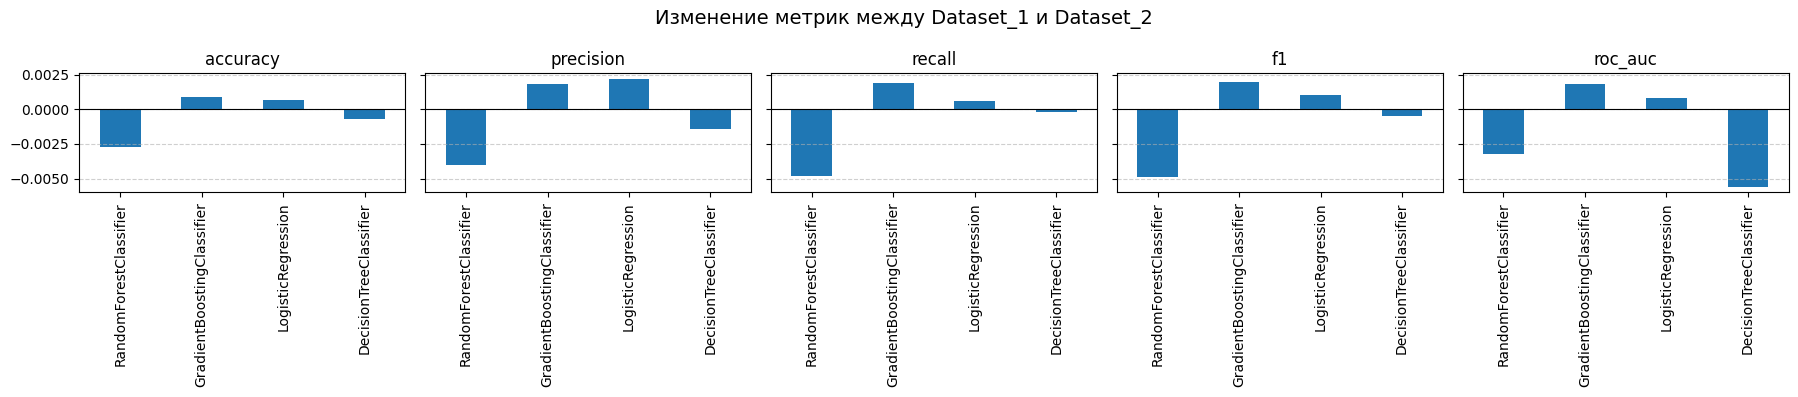

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0027,-0.0040,-0.0048,-0.0049,-0.0032
GradientBoostingClassifier,0.0009,0.0018,0.0019,0.0020,0.0018
LogisticRegression,0.0007,0.0022,0.0006,0.0010,0.0008
DecisionTreeClassifier,-0.0007,-0.0014,-0.0002,-0.0005,-0.0056


In [103]:
compare_datasets_results(initial_metrics, Diff_metrics)

In [ ]:
#Теперь удаляем столбцы из которых делали новые фичи
X_train_preprocessed_diff_delete = X_train_preprocessed_diff.copy()

X_train_preprocessed_diff_delete.drop(['Temp3pm', 'Temp9am', 'Humidity3pm', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'WindSpeed3pm', 'WindSpeed9am'], axis=1, inplace=True)


In [105]:
Diff_metrics_delete =evaluate_models_cv(
    models=models,
    X=X_train_preprocessed_diff_delete,
    y=y_train,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.8108
Precision: 0.7537
Recall:    0.6269
F1 Score:  0.6488
ROC AUC:   0.7886

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8159
Precision: 0.7465
Recall:    0.6633
F1 Score:  0.6865
ROC AUC:   0.7972

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8351
Precision: 0.7875
Recall:    0.6916
F1 Score:  0.7197
ROC AUC:   0.8456

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8298
Precision: 0.7792
Recall:    0.6795
F1 Score:  0.7071
ROC AUC:   0.8326

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8351     0.7875  0.6916 0.7197   0.8456
GradientBoostingClassifier    0.8298     0.7792  0.6795 0.7071   0.8326
DecisionTreeClassifier        0.8159     0.7465  0.6633 0.6865   0.7972
LogisticRegression            0.8108     0.7537  0.6269 0.6488   0.7886



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0198    -0.0315 -0.0392 -0.0406  -0.0367
GradientBoostingClassifier   -0.0179    -0.0258 -0.0402 -0.0408  -0.0344
LogisticRegression           -0.0269    -0.0332 -0.0755 -0.0805  -0.0593
DecisionTreeClassifier       -0.0216    -0.0346 -0.0484 -0.0492  -0.0424


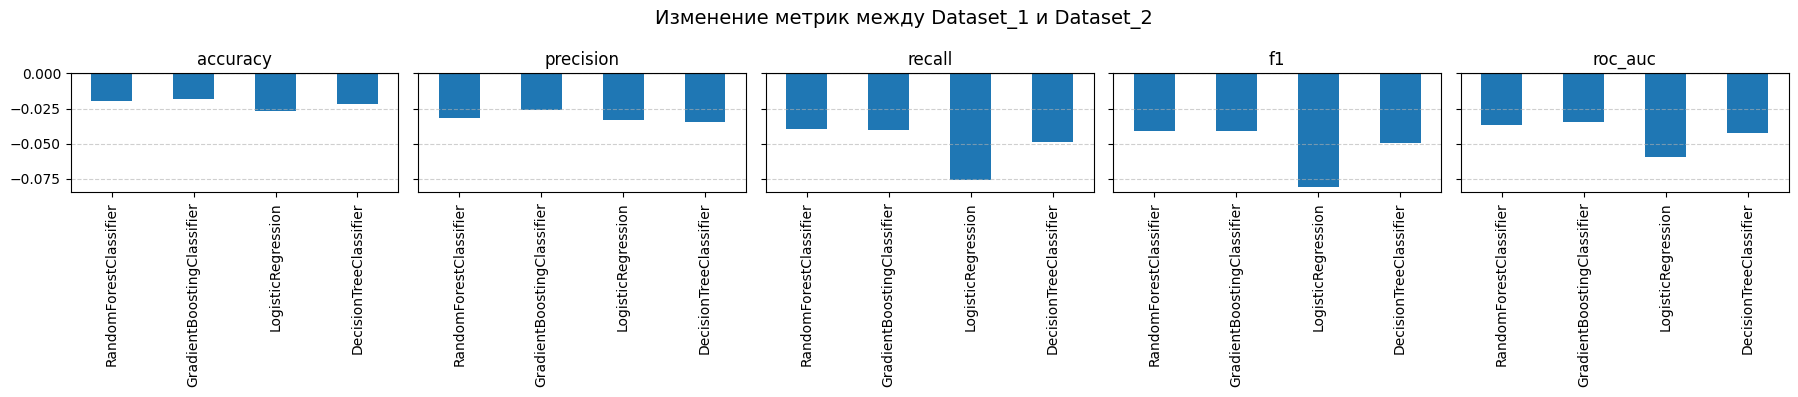

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0198,-0.0315,-0.0392,-0.0406,-0.0367
GradientBoostingClassifier,-0.0179,-0.0258,-0.0402,-0.0408,-0.0344
LogisticRegression,-0.0269,-0.0332,-0.0755,-0.0805,-0.0593
DecisionTreeClassifier,-0.0216,-0.0346,-0.0484,-0.0492,-0.0424


In [ ]:
compare_datasets_results(initial_metrics, Diff_metrics_delete)#Видим что результаты только ухудшились

In [ ]:
#Добавляем фичи которые будут вычислять некоторые признаки на основе предыдущих 3 дней
X_train_preprocessed_3days = X_train_preprocessed.copy()
X_train_preprocessed_3days['RainToday_3'] = X_train_preprocessed_3days['RainToday'].rolling(window=3).sum().fillna(X_train_preprocessed_3days['RainToday'].mean())
X_train_preprocessed_3days['MinTemp_3'] = X_train_preprocessed_3days['MinTemp'].rolling(window=3).mean().fillna(X_train_preprocessed_3days['MinTemp'].mean())
X_train_preprocessed_3days['MaxTemp_3'] = X_train_preprocessed_3days['MaxTemp'].rolling(window=3).mean().fillna(X_train_preprocessed_3days['MaxTemp'].mean())
X_train_preprocessed_3days['Rainfall_3'] = X_train_preprocessed_3days['Rainfall'].rolling(window=3).mean().fillna(X_train_preprocessed_3days['Rainfall'].mean())
X_train_preprocessed_3days['Humidity9am_3'] = X_train_preprocessed_3days['Humidity9am'].rolling(window=3).mean().fillna(X_train_preprocessed_3days['Humidity9am'].mean())
X_train_preprocessed_3days['Humidity3pm_3'] =X_train_preprocessed_3days['Humidity3pm'].rolling(window=3).mean().fillna(X_train_preprocessed_3days['Humidity3pm'].mean())

In [109]:
days3_metrics =evaluate_models_cv(
    models=models,
    X=X_train_preprocessed_3days,
    y=y_train,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.8381
Precision: 0.7887
Recall:    0.7028
F1 Score:  0.7300
ROC AUC:   0.8490

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8349
Precision: 0.7761
Recall:    0.7087
F1 Score:  0.7320
ROC AUC:   0.8341

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8509
Precision: 0.8142
Recall:    0.7216
F1 Score:  0.7516
ROC AUC:   0.8734

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8479
Precision: 0.8052
Recall:    0.7209
F1 Score:  0.7490
ROC AUC:   0.8679

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8509     0.8142  0.7216 0.7516   0.8734
GradientBoostingClassifier    0.8479     0.8052  0.7209 0.7490   0.8679
LogisticRegression            0.8381     0.7887  0.7028 0.7300   0.8490
DecisionTreeClassifier        0.8349     0.7761  0.7087 0.7320   0.8341



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0040    -0.0047 -0.0092 -0.0088  -0.0089
GradientBoostingClassifier    0.0002     0.0002  0.0012  0.0011   0.0009
LogisticRegression            0.0005     0.0018  0.0004  0.0007   0.0010
DecisionTreeClassifier       -0.0026    -0.0050 -0.0030 -0.0036  -0.0056


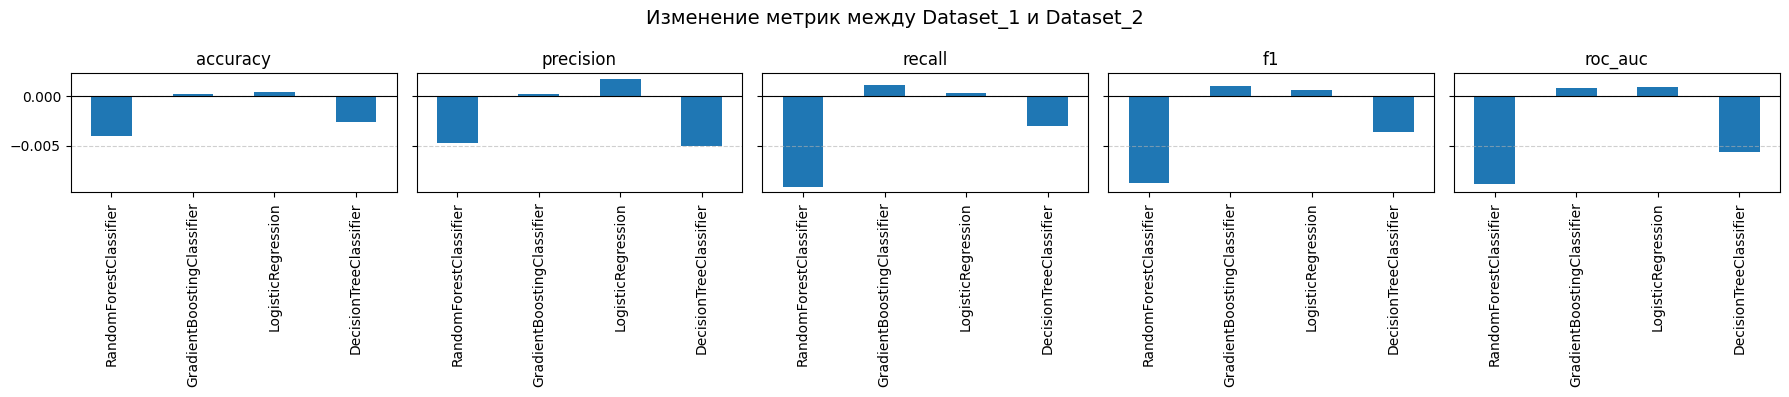

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0040,-0.0047,-0.0092,-0.0088,-0.0089
GradientBoostingClassifier,0.0002,0.0002,0.0012,0.0011,0.0009
LogisticRegression,0.0005,0.0018,0.0004,0.0007,0.0010
DecisionTreeClassifier,-0.0026,-0.0050,-0.0030,-0.0036,-0.0056


In [ ]:
compare_datasets_results(initial_metrics, days3_metrics)#Немного улучшились результаты для лог рег и град бустинга

In [74]:
smote = SMOTE(
    sampling_strategy='auto',
    random_state=SEED,
    k_neighbors=5
)


In [ ]:
X_train_preprocessed_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)#Используем SMOTE для борьбы с дисбалансом классов


In [76]:
Smote_metrics =evaluate_models_cv(
    models=models,
    X=X_train_preprocessed_smote,
    y=y_train_smote,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.7703
Precision: 0.7706
Recall:    0.7703
F1 Score:  0.7703
ROC AUC:   0.8532

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.8217
Precision: 0.8228
Recall:    0.8217
F1 Score:  0.8215
ROC AUC:   0.9000

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.9082
Precision: 0.9083
Recall:    0.9082
F1 Score:  0.9082
ROC AUC:   0.9696

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8627
Precision: 0.8631
Recall:    0.8627
F1 Score:  0.8627
ROC AUC:   0.9386

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.9082     0.9083  0.9082 0.9082   0.9696
GradientBoostingClassifier    0.8627     0.8631  0.8627 0.8627   0.9386
DecisionTreeClassifier        0.8217     0.8228  0.8217 0.8215   0.9000
LogisticRegression            0.7703     0.7706  0.7703 0.7703   0.8532



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier        0.0522     0.0877  0.1754  0.1458   0.0864
GradientBoostingClassifier    0.0144     0.0568  0.1420  0.1136   0.0718
LogisticRegression           -0.0674    -0.0167  0.0680  0.0410   0.0051
DecisionTreeClassifier       -0.0177     0.0380  0.1079  0.0833   0.0610


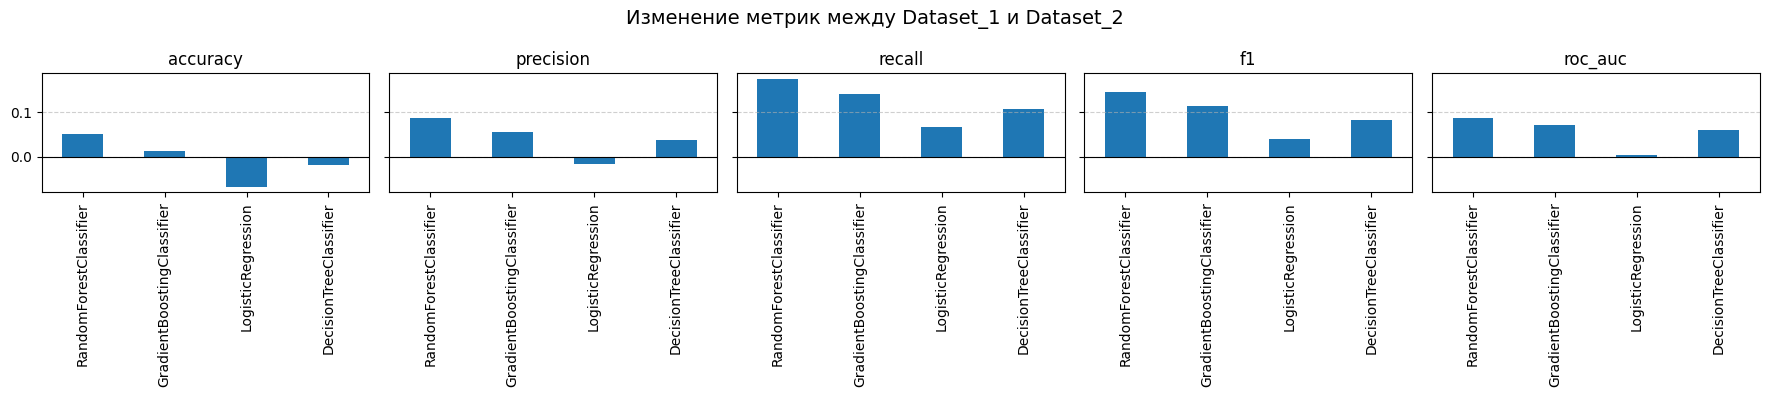

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,0.0522,0.0877,0.1754,0.1458,0.0864
GradientBoostingClassifier,0.0144,0.0568,0.1420,0.1136,0.0718
LogisticRegression,-0.0674,-0.0167,0.0680,0.0410,0.0051
DecisionTreeClassifier,-0.0177,0.0380,0.1079,0.0833,0.0610


In [ ]:
compare_datasets_results(initial_metrics, Smote_metrics)#Видим знавчительное улучшение метрик 

In [ ]:
#Проверяем улучшатся ли показатель при добавлении аргумента class_weight='balanced'
models_weight = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, class_weight='balanced')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=10, class_weight='balanced')),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=SEED))
]

In [ ]:
initial_metrics_class_weight = evaluate_models_cv(
    models=models_weight,
    X=X_train_preprocessed,
    y=y_train,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.7789
Precision: 0.7104
Recall:    0.7686
F1 Score:  0.7251
ROC AUC:   0.8501

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.7791
Precision: 0.7090
Recall:    0.7644
F1 Score:  0.7237
ROC AUC:   0.8323

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8505
Precision: 0.8186
Recall:    0.7157
F1 Score:  0.7473
ROC AUC:   0.8822

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8478
Precision: 0.8052
Recall:    0.7208
F1 Score:  0.7489
ROC AUC:   0.8679

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8505     0.8186  0.7157 0.7473   0.8822
GradientBoostingClassifier    0.8478     0.8052  0.7208 0.7489   0.8679
LogisticRegression            0.7789     0.7104  0.7686 0.7251   0.8501
DecisionTreeClassifier        0.7791     0.7090  0.7644 0.7237   0.8323



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0044    -0.0003 -0.0151 -0.0130  -0.0002
GradientBoostingClassifier    0.0002     0.0002  0.0012  0.0010   0.0009
LogisticRegression           -0.0587    -0.0765  0.0661 -0.0042   0.0021
DecisionTreeClassifier       -0.0585    -0.0721  0.0528 -0.0120  -0.0073


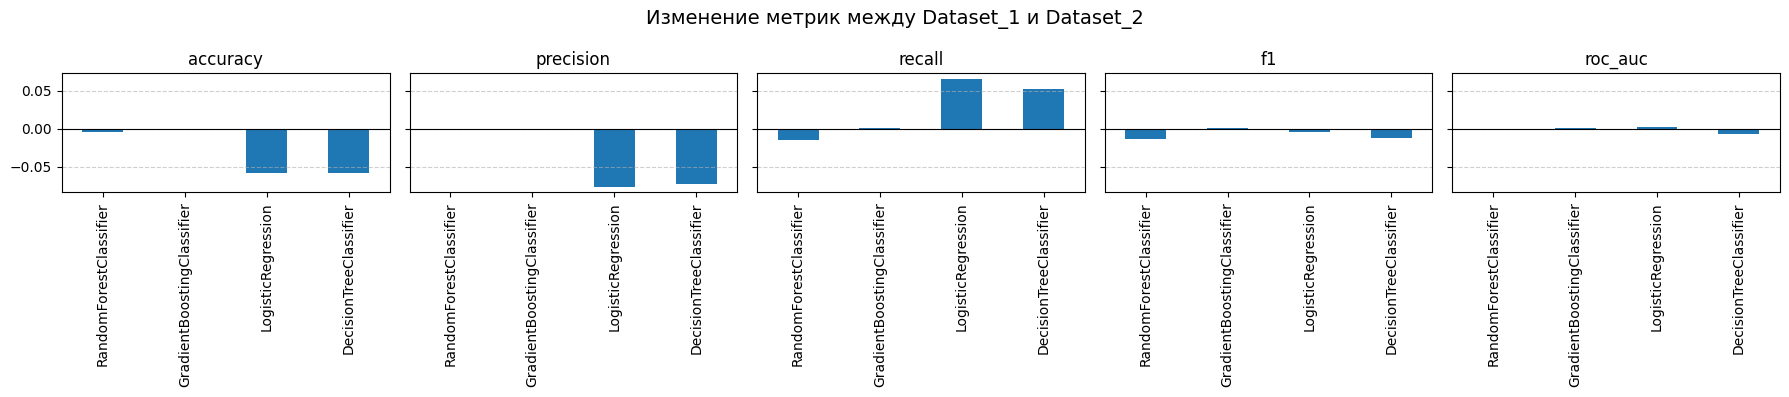

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0044,-0.0003,-0.0151,-0.0130,-0.0002
GradientBoostingClassifier,0.0002,0.0002,0.0012,0.0010,0.0009
LogisticRegression,-0.0587,-0.0765,0.0661,-0.0042,0.0021
DecisionTreeClassifier,-0.0585,-0.0721,0.0528,-0.0120,-0.0073


In [ ]:
compare_datasets_results(initial_metrics, initial_metrics_class_weight)#немного лучше стали результаты на гралд бустинге, в остальных случаях ухудшились

In [ ]:
#Видим что улучшение модели произошло только благодаря использованию SMOTE

In [120]:
X_train_preprocessed_target = X_train_preprocessed.copy()
X_train_preprocessed_target['City_cat'] = X_train_preprocessed_target['Location'].astype(str)

# Объединяем с y_train для группировки
df_ = X_train_preprocessed_target.copy()
df_['y_train'] = y_train.values  # создаём колонку y_train в df

# Target encoding
target_means = df_.groupby('City_cat')['y_train'].mean()
X_train_preprocessed_target['City_te'] = X_train_preprocessed_target['City_cat'].map(target_means)

# Убираем лишние колонки
X_train_preprocessed_target.drop(['Location', 'City_cat'], axis=1, inplace=True)



In [121]:
initial_metrics_target = evaluate_models_cv(
    models=models_weight,
    X=X_train_preprocessed_target,
    y=y_train,
    cv=cv,
    seed=SEED
)


Кросс-валидация модели: LogisticRegression
Accuracy:  0.7783
Precision: 0.7102
Recall:    0.7687
F1 Score:  0.7248
ROC AUC:   0.8511

Кросс-валидация модели: DecisionTreeClassifier
Accuracy:  0.7805
Precision: 0.7105
Recall:    0.7661
F1 Score:  0.7253
ROC AUC:   0.8346

Кросс-валидация модели: RandomForestClassifier
Accuracy:  0.8526
Precision: 0.8226
Recall:    0.7193
F1 Score:  0.7513
ROC AUC:   0.8842

Кросс-валидация модели: GradientBoostingClassifier
Accuracy:  0.8479
Precision: 0.8051
Recall:    0.7212
F1 Score:  0.7492
ROC AUC:   0.8686

=== Сводная таблица метрик (усреднённые по CV) ===
                            accuracy  precision  recall     f1  roc_auc
RandomForestClassifier        0.8526     0.8226  0.7193 0.7513   0.8842
GradientBoostingClassifier    0.8479     0.8051  0.7212 0.7492   0.8686
LogisticRegression            0.7783     0.7102  0.7687 0.7248   0.8511
DecisionTreeClassifier        0.7805     0.7105  0.7661 0.7253   0.8346



=== Разница метрик (Dataset_2 - Dataset_1) ===
                            accuracy  precision  recall      f1  roc_auc
RandomForestClassifier       -0.0023     0.0037 -0.0115 -0.0090   0.0019
GradientBoostingClassifier    0.0003     0.0001  0.0016  0.0013   0.0016
LogisticRegression           -0.0593    -0.0767  0.0663 -0.0045   0.0031
DecisionTreeClassifier       -0.0570    -0.0706  0.0544 -0.0103  -0.0050


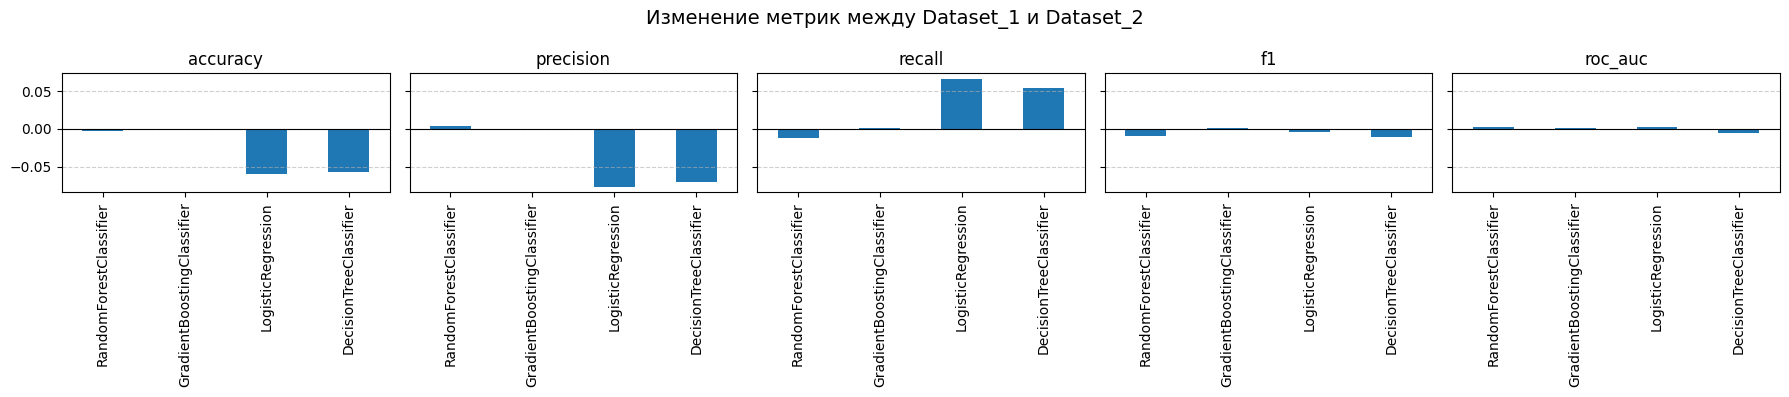

,accuracy,precision,recall,f1,roc_auc
RandomForestClassifier,-0.0023,0.0037,-0.0115,-0.0090,0.0019
GradientBoostingClassifier,0.0003,0.0001,0.0016,0.0013,0.0016
LogisticRegression,-0.0593,-0.0767,0.0663,-0.0045,0.0031
DecisionTreeClassifier,-0.0570,-0.0706,0.0544,-0.0103,-0.0050


In [122]:
compare_datasets_results(initial_metrics, initial_metrics_target)

In [78]:
param_grids = {
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']},
    'DecisionTreeClassifier': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'RandomForestClassifier': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'GradientBoostingClassifier': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth':[3,5, 7]}
}

best_models = {}

for name, model in models:
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=cv,
        scoring='f1',  # или любая метрика
        n_jobs=-1, 
        verbose=2
    )
    grid.fit(X_train_preprocessed_smote, y_train_smote)
    best_models[name] = grid.best_estimator_
    print(f"{name} best params: {grid.best_params_} score: {grid.best_score_:.4f}")


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\dima2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression best params: {'C': 0.1, 'penalty': 'l2'} score: 0.7670
Fitting 5 folds for each of 9 candidates, totalling 45 fits
DecisionTreeClassifier best params: {'max_depth': 20, 'min_samples_split': 2} score: 0.8424
Fitting 5 folds for each of 9 candidates, totalling 45 fits
RandomForestClassifier best params: {'max_depth': None, 'n_estimators': 200} score: 0.9086
Fitting 5 folds for each of 27 candidates, totalling 135 fits
GradientBoostingClassifier best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300} score: 0.9080


In [ ]:
best_models[' 'RandomForestClassifier'']

In [ ]:
#Лучшие параметры RandomForestClassifier best params: {'max_depth': None, 'n_estimators': 200}, 
#Лучшие параметры GradientBoostingClassifier best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
#RandomForestClassifier ЛУЧШИЙ РЕЗУЛЬТАТ F1score=0.9086
# GradientBoostingClassifier ЛУЧШИЙ РЕЗУЛЬТАТ F1score=0.9080

In [44]:
new_df['Season']=new_df['Month'].apply(get_season)
new_df_2 = one_hot_encode_df(new_df, ['Season'])
print(new_df_2.columns)


Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainTomorrow', 'WindGustDir_E',
       'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
       'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S',
       'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_SSW',
       'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW', 'WindGustDir_WSW',
       'WindGustDir_missing', 'WindDir9am_E', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
       'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W',
       'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir9am_missing',
       'WindDir3pm_E', 'WindDir3pm_ENE', 'WindDir3pm_ESE', 'WindDir3pm_N',
       'WindDir3pm_NE', 'WindDir3pm_NNE', 'Wind